In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [36]:
import keras.utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv('Data/16M_7_day_lag_with_price_changes.csv', 
                 usecols=['date', 'compound', 'negative', 'positive', 'daily_count', 'price_direction', 'price_change', 'lagged_close'])

In [5]:
df = df[df['date'] >= '2018-08-28']

In [6]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [7]:
df['price_change'] = df.apply(lambda row: -1 * row['price_change'] if row['price_direction'] == 'negative' else row['price_change'], axis=1)

In [8]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,-254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,-449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,-570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,-967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,-987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,-495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,-179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [9]:
min_change = df['price_change'].min()
max_change = df['price_change'].max()

print(f'Min: {min_change}')
print(f'Max: {max_change}') 

Min: -3096.1708984375
Max: 3742.7099609375


In [10]:
# Create bins
bins = [float("-inf"), -330, 0., 330, float("inf")]
labels = [0, 1, 2, 3]

# Put records into bins
df['price_change'] = pd.cut(x=df['price_change'], bins=bins, labels=labels, include_lowest=True)
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,2,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,1,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,0,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,0,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,0,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,0,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,0,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,1,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,3,positive


In [11]:
df['price_change'].value_counts()

1    124
2    123
0    111
3     95
Name: price_change, dtype: int64

In [12]:
# Copying df for further manipulations
df_copy = df.copy()

In [13]:
features = ['price_change', 'lagged_close', 'positive', 'negative', 'daily_count']

In [14]:
df_copy = df_copy[features]

In [15]:
# Number of previous records to consider for every example (Window size)
n_lag = 3

# Number of features
n_features = len(features)

# Calculate total_features
total_features = n_lag * n_features

if(total_features == 0):
    total_features = n_features

In [16]:
def create_lagged_features(data, n_lagged_features=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns, names = list(), list()
    
    for i in range(n_lagged_features, 0, -1):
        columns.append(df.shift(i))
        names += [f'feature{j+1}(t-{i})' for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [f'feature{j+1}(t)' for j in range(variables)]
        else:
            names += [f'feature{j+1}(t+{i})' for j in range(variables)]
            
    prepped_df = pd.concat(columns, axis=1)
    prepped_df.columns = names
    
    # Drop rows with NaN values
    prepped_df.dropna(inplace=True)
        
    return prepped_df

In [17]:
# Create lagged data (previous data window) columns
lagged_data = create_lagged_features(df_copy, n_lag, 1)
lagged_data = lagged_data.reset_index()
lagged_data = lagged_data.drop(['index'], axis=1)

In [18]:
lagged_data

,feature1(t-3),feature2(t-3),feature3(t-3),feature4(t-3),feature5(t-3),feature1(t-2),feature2(t-2),feature3(t-2),feature4(t-2),feature5(t-2),feature1(t-1),feature2(t-1),feature3(t-1),feature4(t-1),feature5(t-1),feature1(t),feature2(t),feature3(t),feature4(t),feature5(t)
0,2,7361.660156,0.028635,0.007695,750.0,1,6792.830078,0.028844,0.006276,736.0,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682
1,1,6792.830078,0.028844,0.006276,736.0,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642
2,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659
3,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707
4,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707.0,0,6321.200195,0.025445,0.006964,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,7397.796875,0.093754,0.039901,33199.0,0,7047.916992,0.092225,0.039410,33029.0,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287
446,0,7047.916992,0.092225,0.039410,33029.0,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112
447,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112.0,1,7463.105957,0.096216,0.042986,47978
448,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112.0,1,7463.105957,0.096216,0.042986,47978.0,3,7761.243652,0.090741,0.048450,51043


In [19]:
X = lagged_data.iloc[:, :total_features].values
y = lagged_data['feature1(t)'].values

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

In [21]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (382, 15) (382,)
Testing set shape: (68, 15) (68,)


In [22]:
# Normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

In [23]:
# Reshape to match LSTM input [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))

In [24]:
X_train.shape

(382, 3, 5)

In [25]:
# Set two class values (1-hot method)
y_train = keras.utils.to_categorical(y_train, 4)

### LSTM Model

In [26]:
EPOCHS = 10000

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [28]:
y_eval = keras.utils.to_categorical(y_test, 4)

In [29]:
# Optimize hyperparameters
import optuna

In [30]:
np.random.seed(1) 
tf.random.set_seed(1)

In [34]:
def objective(trial):
    activation_funcs = ['relu', 'tanh', 'selu', 'swish']
    
    # Hyperparameters that will be changed
    activation_func_1 = trial.suggest_categorical('activation_func_1', activation_funcs)
    activation_func_2 = trial.suggest_categorical('activation_func_2', activation_funcs)
#     activation_func_3 = trial.suggest_categorical('activation_func_3', activation_funcs)
    batch_size = trial.suggest_categorical('batch_size', [32, 50, 64, 80])
    dropout_1 = trial.suggest_categorical('dropout_1', [0.25, 0.5])
    dropout_2 = trial.suggest_categorical('dropout_2', [0.25, 0.5])
#     dropout_3 = trial.suggest_categorical('dropout_3', [0.25, 0.5])
    neurons = trial.suggest_categorical('neurons', [64, 128, 256])
    
    model = Sequential()
    model.add(Conv1D(neurons, 
                     kernel_size=2, 
                     padding='same', 
                     input_shape=(X_train.shape[1], X_train.shape[2]), activation=activation_func_1))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(dropout_1))

    model.add(Conv1D(neurons, kernel_size=2, padding='same', activation=activation_func_2))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(dropout_2))

    # Flatten and add a dense layer and to output the prediction
    model.add(Flatten())
    model.add(Dense(4, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
      
    model.fit(X_train, 
              y_train, 
              epochs=EPOCHS,
              batch_size=batch_size, 
              verbose=2, 
              shuffle=True,
              validation_split=0.2, 
              callbacks=[early_stopping])
    
    # Evaluate the model on the validation data
    validation_accuracy = model.evaluate(X_test, y_eval)[1]

    return validation_accuracy

In [32]:
import time

In [38]:
study = optuna.create_study(storage='sqlite:///db.sqlite3', 
                            study_name='CNN_magnitude_change_7_day_lag_3_day_window',
                            direction='maximize')

start_time = time.time()

study.optimize(objective, n_trials=100)

elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.2f} seconds')

[I 2023-07-27 08:37:07,943] A new study created in RDB with name: CNN_magnitude_change_7_day_lag_3_day_window


Epoch 1/10000
7/7 - 1s - loss: 1.3891 - accuracy: 0.3180 - val_loss: 1.3480 - val_accuracy: 0.4156 - 1s/epoch - 151ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3273 - accuracy: 0.4852 - val_loss: 1.3138 - val_accuracy: 0.4156 - 47ms/epoch - 7ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.2774 - accuracy: 0.5410 - val_loss: 1.2820 - val_accuracy: 0.4286 - 47ms/epoch - 7ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2412 - accuracy: 0.5344 - val_loss: 1.2483 - val_accuracy: 0.4286 - 46ms/epoch - 7ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2133 - accuracy: 0.5508 - val_loss: 1.2285 - val_accuracy: 0.4156 - 44ms/epoch - 6ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.1683 - accuracy: 0.5508 - val_loss: 1.2084 - val_accuracy: 0.4416 - 47ms/epoch - 7ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.1592 - accuracy: 0.5869 - val_loss: 1.1920 - val_accuracy: 0.4416 - 46ms/epoch - 7ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.1540 - accuracy: 0.5607 - val_loss: 1.1760 - val_accuracy: 0.4416 - 45ms/epoch - 6ms/step
Epoch 9/10000
7/

[I 2023-07-27 08:37:12,276] Trial 0 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 128}. Best is trial 0 with value: 0.6617646813392639.


Epoch 1/10000
4/4 - 1s - loss: 1.3346 - accuracy: 0.3180 - val_loss: 1.2762 - val_accuracy: 0.3506 - 831ms/epoch - 208ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.2419 - accuracy: 0.4852 - val_loss: 1.2041 - val_accuracy: 0.4545 - 47ms/epoch - 12ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.1781 - accuracy: 0.5377 - val_loss: 1.1496 - val_accuracy: 0.4545 - 45ms/epoch - 11ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.1618 - accuracy: 0.5180 - val_loss: 1.1168 - val_accuracy: 0.4545 - 41ms/epoch - 10ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.1146 - accuracy: 0.5705 - val_loss: 1.1000 - val_accuracy: 0.4805 - 41ms/epoch - 10ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.0985 - accuracy: 0.5803 - val_loss: 1.0866 - val_accuracy: 0.4935 - 42ms/epoch - 10ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.0833 - accuracy: 0.5902 - val_loss: 1.0706 - val_accuracy: 0.4935 - 43ms/epoch - 11ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.0701 - accuracy: 0.5803 - val_loss: 1.0424 - val_accuracy: 0.5325 - 43ms/epoch - 11ms/step
Epoch 

[I 2023-07-27 08:37:16,732] Trial 1 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 256}. Best is trial 0 with value: 0.6617646813392639.


Epoch 1/10000
5/5 - 1s - loss: 1.2843 - accuracy: 0.3836 - val_loss: 1.1941 - val_accuracy: 0.4545 - 823ms/epoch - 165ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.1418 - accuracy: 0.5639 - val_loss: 1.1114 - val_accuracy: 0.4805 - 46ms/epoch - 9ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.1170 - accuracy: 0.5967 - val_loss: 1.0999 - val_accuracy: 0.5325 - 47ms/epoch - 9ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.0989 - accuracy: 0.6033 - val_loss: 1.0709 - val_accuracy: 0.5195 - 45ms/epoch - 9ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.0470 - accuracy: 0.5803 - val_loss: 1.0062 - val_accuracy: 0.5714 - 48ms/epoch - 10ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.0244 - accuracy: 0.6000 - val_loss: 0.9965 - val_accuracy: 0.5714 - 52ms/epoch - 10ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.9987 - accuracy: 0.6131 - val_loss: 0.9760 - val_accuracy: 0.5714 - 53ms/epoch - 11ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.9832 - accuracy: 0.6066 - val_loss: 0.9492 - val_accuracy: 0.5844 - 52ms/epoch - 10ms/step
Epoch 9/1

[I 2023-07-27 08:37:19,832] Trial 2 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 256}. Best is trial 0 with value: 0.6617646813392639.


Epoch 1/10000
5/5 - 1s - loss: 1.3742 - accuracy: 0.2623 - val_loss: 1.3663 - val_accuracy: 0.2078 - 846ms/epoch - 169ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3486 - accuracy: 0.3607 - val_loss: 1.3454 - val_accuracy: 0.3766 - 42ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3223 - accuracy: 0.4000 - val_loss: 1.3235 - val_accuracy: 0.3766 - 41ms/epoch - 8ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2945 - accuracy: 0.4689 - val_loss: 1.2989 - val_accuracy: 0.4675 - 45ms/epoch - 9ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2702 - accuracy: 0.5115 - val_loss: 1.2726 - val_accuracy: 0.4416 - 41ms/epoch - 8ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2399 - accuracy: 0.5049 - val_loss: 1.2469 - val_accuracy: 0.4545 - 41ms/epoch - 8ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2150 - accuracy: 0.5279 - val_loss: 1.2224 - val_accuracy: 0.4545 - 41ms/epoch - 8ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1838 - accuracy: 0.5377 - val_loss: 1.2002 - val_accuracy: 0.4416 - 42ms/epoch - 8ms/step
Epoch 9/10000

[I 2023-07-27 08:37:24,647] Trial 3 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 128}. Best is trial 3 with value: 0.6764705777168274.


Epoch 1/10000
5/5 - 1s - loss: 1.3916 - accuracy: 0.2393 - val_loss: 1.3769 - val_accuracy: 0.3636 - 803ms/epoch - 161ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3523 - accuracy: 0.3377 - val_loss: 1.3534 - val_accuracy: 0.3636 - 38ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3382 - accuracy: 0.3574 - val_loss: 1.3305 - val_accuracy: 0.4156 - 38ms/epoch - 8ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3079 - accuracy: 0.4656 - val_loss: 1.3074 - val_accuracy: 0.4675 - 38ms/epoch - 8ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2902 - accuracy: 0.4787 - val_loss: 1.2841 - val_accuracy: 0.4675 - 36ms/epoch - 7ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2707 - accuracy: 0.4918 - val_loss: 1.2622 - val_accuracy: 0.4675 - 37ms/epoch - 7ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2336 - accuracy: 0.5115 - val_loss: 1.2421 - val_accuracy: 0.4675 - 37ms/epoch - 7ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2252 - accuracy: 0.5180 - val_loss: 1.2207 - val_accuracy: 0.4675 - 36ms/epoch - 7ms/step
Epoch 9/10000

[I 2023-07-27 08:37:29,203] Trial 4 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
4/4 - 1s - loss: 1.3876 - accuracy: 0.2557 - val_loss: 1.3804 - val_accuracy: 0.2078 - 837ms/epoch - 209ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3611 - accuracy: 0.2951 - val_loss: 1.3670 - val_accuracy: 0.2727 - 36ms/epoch - 9ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3477 - accuracy: 0.3639 - val_loss: 1.3536 - val_accuracy: 0.3506 - 35ms/epoch - 9ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3348 - accuracy: 0.3639 - val_loss: 1.3393 - val_accuracy: 0.3766 - 35ms/epoch - 9ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3233 - accuracy: 0.4098 - val_loss: 1.3233 - val_accuracy: 0.4026 - 34ms/epoch - 9ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3091 - accuracy: 0.4852 - val_loss: 1.3069 - val_accuracy: 0.3896 - 35ms/epoch - 9ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2878 - accuracy: 0.5049 - val_loss: 1.2893 - val_accuracy: 0.4416 - 34ms/epoch - 9ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2726 - accuracy: 0.5639 - val_loss: 1.2702 - val_accuracy: 0.4416 - 35ms/epoch - 9ms/step
Epoch 9/10000

4/4 - 0s - loss: 0.8720 - accuracy: 0.6623 - val_loss: 0.9038 - val_accuracy: 0.6494 - 45ms/epoch - 11ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8759 - accuracy: 0.6984 - val_loss: 0.9019 - val_accuracy: 0.6494 - 35ms/epoch - 9ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8701 - accuracy: 0.6557 - val_loss: 0.8986 - val_accuracy: 0.6494 - 36ms/epoch - 9ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8743 - accuracy: 0.6754 - val_loss: 0.8991 - val_accuracy: 0.6494 - 36ms/epoch - 9ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8484 - accuracy: 0.6754 - val_loss: 0.8985 - val_accuracy: 0.6494 - 36ms/epoch - 9ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8538 - accuracy: 0.6656 - val_loss: 0.8989 - val_accuracy: 0.6494 - 36ms/epoch - 9ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8632 - accuracy: 0.6557 - val_loss: 0.8996 - val_accuracy: 0.6494 - 36ms/epoch - 9ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8574 - accuracy: 0.6656 - val_loss: 0.8955 - val_accuracy: 0.6494 - 36ms/epoch - 9ms/step
Epoch 75/10000
4/4 - 0

[I 2023-07-27 08:37:34,335] Trial 5 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3724 - accuracy: 0.3016 - val_loss: 1.3186 - val_accuracy: 0.3766 - 889ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3137 - accuracy: 0.3639 - val_loss: 1.2815 - val_accuracy: 0.4675 - 43ms/epoch - 4ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2792 - accuracy: 0.4393 - val_loss: 1.2498 - val_accuracy: 0.4545 - 43ms/epoch - 4ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2615 - accuracy: 0.4295 - val_loss: 1.2190 - val_accuracy: 0.4416 - 43ms/epoch - 4ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2125 - accuracy: 0.4951 - val_loss: 1.1867 - val_accuracy: 0.4675 - 42ms/epoch - 4ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1632 - accuracy: 0.5344 - val_loss: 1.1598 - val_accuracy: 0.4805 - 43ms/epoch - 4ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2115 - accuracy: 0.4590 - val_loss: 1.1370 - val_accuracy: 0.4805 - 43ms/epoch - 4ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1456 - accuracy: 0.5377 - val_loss: 1.1168 - val_accuracy: 0.4805 - 43ms/epoch - 4ms/ste

[I 2023-07-27 08:37:38,771] Trial 6 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
4/4 - 1s - loss: 1.3714 - accuracy: 0.2721 - val_loss: 1.3171 - val_accuracy: 0.3506 - 795ms/epoch - 199ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.2893 - accuracy: 0.4098 - val_loss: 1.2620 - val_accuracy: 0.4156 - 38ms/epoch - 9ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.2264 - accuracy: 0.4623 - val_loss: 1.2015 - val_accuracy: 0.4286 - 39ms/epoch - 10ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.1897 - accuracy: 0.5279 - val_loss: 1.1583 - val_accuracy: 0.4675 - 38ms/epoch - 9ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.1560 - accuracy: 0.5180 - val_loss: 1.1329 - val_accuracy: 0.4935 - 38ms/epoch - 9ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.1399 - accuracy: 0.5508 - val_loss: 1.1237 - val_accuracy: 0.4935 - 37ms/epoch - 9ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.1126 - accuracy: 0.5836 - val_loss: 1.1163 - val_accuracy: 0.4935 - 37ms/epoch - 9ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.0987 - accuracy: 0.5934 - val_loss: 1.1025 - val_accuracy: 0.4935 - 37ms/epoch - 9ms/step
Epoch 9/1000

[I 2023-07-27 08:37:42,784] Trial 7 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 128}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
4/4 - 1s - loss: 1.3875 - accuracy: 0.2787 - val_loss: 1.3682 - val_accuracy: 0.3377 - 928ms/epoch - 232ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3442 - accuracy: 0.3639 - val_loss: 1.3450 - val_accuracy: 0.3766 - 39ms/epoch - 10ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3162 - accuracy: 0.4295 - val_loss: 1.3170 - val_accuracy: 0.3636 - 39ms/epoch - 10ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.2873 - accuracy: 0.4328 - val_loss: 1.2846 - val_accuracy: 0.4156 - 51ms/epoch - 13ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2614 - accuracy: 0.5213 - val_loss: 1.2531 - val_accuracy: 0.4416 - 42ms/epoch - 10ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2341 - accuracy: 0.5279 - val_loss: 1.2257 - val_accuracy: 0.4805 - 38ms/epoch - 10ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2037 - accuracy: 0.5672 - val_loss: 1.2018 - val_accuracy: 0.4675 - 36ms/epoch - 9ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1738 - accuracy: 0.5738 - val_loss: 1.1795 - val_accuracy: 0.4416 - 39ms/epoch - 10ms/step
Epoch 9

[I 2023-07-27 08:37:47,360] Trial 8 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 128}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
5/5 - 1s - loss: 1.3122 - accuracy: 0.3836 - val_loss: 1.2068 - val_accuracy: 0.3896 - 873ms/epoch - 175ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.2036 - accuracy: 0.4525 - val_loss: 1.1271 - val_accuracy: 0.4416 - 50ms/epoch - 10ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.1304 - accuracy: 0.5574 - val_loss: 1.1066 - val_accuracy: 0.5065 - 47ms/epoch - 9ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.0907 - accuracy: 0.5836 - val_loss: 1.0816 - val_accuracy: 0.5325 - 47ms/epoch - 9ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.1010 - accuracy: 0.5902 - val_loss: 1.0315 - val_accuracy: 0.5455 - 46ms/epoch - 9ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.0452 - accuracy: 0.6000 - val_loss: 1.0146 - val_accuracy: 0.5455 - 49ms/epoch - 10ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.0470 - accuracy: 0.6164 - val_loss: 1.0080 - val_accuracy: 0.5844 - 48ms/epoch - 10ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.0088 - accuracy: 0.6098 - val_loss: 0.9702 - val_accuracy: 0.5455 - 47ms/epoch - 9ms/step
Epoch 9/10

[I 2023-07-27 08:37:50,859] Trial 9 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 256}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3792 - accuracy: 0.3049 - val_loss: 1.3382 - val_accuracy: 0.3766 - 1s/epoch - 116ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3302 - accuracy: 0.3869 - val_loss: 1.3043 - val_accuracy: 0.4026 - 55ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2751 - accuracy: 0.4754 - val_loss: 1.2700 - val_accuracy: 0.4156 - 54ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2358 - accuracy: 0.5180 - val_loss: 1.2350 - val_accuracy: 0.4286 - 48ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2120 - accuracy: 0.5344 - val_loss: 1.2032 - val_accuracy: 0.4156 - 46ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1806 - accuracy: 0.5279 - val_loss: 1.1755 - val_accuracy: 0.4156 - 49ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1649 - accuracy: 0.5410 - val_loss: 1.1508 - val_accuracy: 0.4545 - 47ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1429 - accuracy: 0.5672 - val_loss: 1.1289 - val_accuracy: 0.4545 - 47ms/epoch - 5ms/step


[I 2023-07-27 08:37:55,690] Trial 10 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3718 - accuracy: 0.2656 - val_loss: 1.3717 - val_accuracy: 0.1948 - 849ms/epoch - 85ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3677 - accuracy: 0.3115 - val_loss: 1.3418 - val_accuracy: 0.4156 - 51ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3342 - accuracy: 0.4262 - val_loss: 1.3180 - val_accuracy: 0.4675 - 47ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3184 - accuracy: 0.4066 - val_loss: 1.2948 - val_accuracy: 0.4545 - 47ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2809 - accuracy: 0.4689 - val_loss: 1.2717 - val_accuracy: 0.4545 - 47ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2633 - accuracy: 0.4852 - val_loss: 1.2495 - val_accuracy: 0.4416 - 48ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2431 - accuracy: 0.4623 - val_loss: 1.2269 - val_accuracy: 0.4675 - 47ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2148 - accuracy: 0.5311 - val_loss: 1.2043 - val_accuracy: 0.4675 - 46ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9450 - accuracy: 0.6393 - val_loss: 0.8925 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9003 - accuracy: 0.6459 - val_loss: 0.8902 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8982 - accuracy: 0.6721 - val_loss: 0.8918 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8937 - accuracy: 0.6459 - val_loss: 0.8949 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9058 - accuracy: 0.6689 - val_loss: 0.8974 - val_accuracy: 0.6623 - 47ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9022 - accuracy: 0.6623 - val_loss: 0.8973 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8776 - accuracy: 0.6820 - val_loss: 0.8984 - val_accuracy: 0.6494 - 47ms/epoch - 5ms/step
3/3 [==============================] - 0s 3ms/step - loss: 0.8442 - accuracy: 0.6912


[I 2023-07-27 08:38:01,286] Trial 11 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.4516 - accuracy: 0.2951 - val_loss: 1.3563 - val_accuracy: 0.3636 - 806ms/epoch - 81ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3961 - accuracy: 0.2984 - val_loss: 1.3258 - val_accuracy: 0.4026 - 47ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3066 - accuracy: 0.4295 - val_loss: 1.2877 - val_accuracy: 0.4545 - 47ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2769 - accuracy: 0.4689 - val_loss: 1.2483 - val_accuracy: 0.4416 - 46ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2505 - accuracy: 0.4885 - val_loss: 1.2131 - val_accuracy: 0.4675 - 45ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2332 - accuracy: 0.4885 - val_loss: 1.1857 - val_accuracy: 0.4935 - 47ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1653 - accuracy: 0.5508 - val_loss: 1.1609 - val_accuracy: 0.4805 - 47ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1544 - accuracy: 0.5180 - val_loss: 1.1383 - val_accuracy: 0.4935 - 46ms/epoch - 5ms/ste

[I 2023-07-27 08:38:06,119] Trial 12 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
7/7 - 1s - loss: 1.3888 - accuracy: 0.2754 - val_loss: 1.3610 - val_accuracy: 0.1948 - 936ms/epoch - 134ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3564 - accuracy: 0.3279 - val_loss: 1.3381 - val_accuracy: 0.4416 - 46ms/epoch - 7ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3377 - accuracy: 0.3869 - val_loss: 1.3197 - val_accuracy: 0.4286 - 40ms/epoch - 6ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3173 - accuracy: 0.4295 - val_loss: 1.3003 - val_accuracy: 0.4286 - 42ms/epoch - 6ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2951 - accuracy: 0.4131 - val_loss: 1.2841 - val_accuracy: 0.4286 - 41ms/epoch - 6ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2909 - accuracy: 0.4295 - val_loss: 1.2671 - val_accuracy: 0.4545 - 41ms/epoch - 6ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2410 - accuracy: 0.5049 - val_loss: 1.2503 - val_accuracy: 0.4545 - 42ms/epoch - 6ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2551 - accuracy: 0.4656 - val_loss: 1.2336 - val_accuracy: 0.4545 - 40ms/epoch - 6ms/step
Epoch 9/10000

[I 2023-07-27 08:38:10,150] Trial 13 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3877 - accuracy: 0.2852 - val_loss: 1.3259 - val_accuracy: 0.2727 - 830ms/epoch - 83ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.2955 - accuracy: 0.3902 - val_loss: 1.2823 - val_accuracy: 0.4156 - 50ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2461 - accuracy: 0.4557 - val_loss: 1.2387 - val_accuracy: 0.4675 - 48ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2181 - accuracy: 0.5082 - val_loss: 1.1987 - val_accuracy: 0.4545 - 44ms/epoch - 4ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1827 - accuracy: 0.5279 - val_loss: 1.1694 - val_accuracy: 0.4545 - 44ms/epoch - 4ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1530 - accuracy: 0.5082 - val_loss: 1.1511 - val_accuracy: 0.4805 - 45ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1655 - accuracy: 0.5607 - val_loss: 1.1364 - val_accuracy: 0.5195 - 46ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1286 - accuracy: 0.5541 - val_loss: 1.1093 - val_accuracy: 0.4935 - 45ms/epoch - 5ms/ste

[I 2023-07-27 08:38:14,602] Trial 14 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
5/5 - 1s - loss: 1.3881 - accuracy: 0.2426 - val_loss: 1.3373 - val_accuracy: 0.4026 - 815ms/epoch - 163ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3437 - accuracy: 0.3475 - val_loss: 1.3200 - val_accuracy: 0.4675 - 40ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3438 - accuracy: 0.3672 - val_loss: 1.3016 - val_accuracy: 0.4675 - 38ms/epoch - 8ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3108 - accuracy: 0.4590 - val_loss: 1.2843 - val_accuracy: 0.4675 - 38ms/epoch - 8ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2903 - accuracy: 0.4525 - val_loss: 1.2646 - val_accuracy: 0.4805 - 38ms/epoch - 8ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2588 - accuracy: 0.4721 - val_loss: 1.2447 - val_accuracy: 0.4935 - 38ms/epoch - 8ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2376 - accuracy: 0.5082 - val_loss: 1.2264 - val_accuracy: 0.4935 - 37ms/epoch - 7ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2254 - accuracy: 0.4951 - val_loss: 1.2076 - val_accuracy: 0.4805 - 38ms/epoch - 8ms/step
Epoch 9/10000

5/5 - 0s - loss: 0.9426 - accuracy: 0.6164 - val_loss: 0.9095 - val_accuracy: 0.6494 - 38ms/epoch - 8ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.9176 - accuracy: 0.6426 - val_loss: 0.9079 - val_accuracy: 0.6494 - 38ms/epoch - 8ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.9235 - accuracy: 0.6656 - val_loss: 0.9066 - val_accuracy: 0.6494 - 37ms/epoch - 7ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9480 - accuracy: 0.6656 - val_loss: 0.9057 - val_accuracy: 0.6364 - 39ms/epoch - 8ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.8959 - accuracy: 0.6557 - val_loss: 0.9079 - val_accuracy: 0.6364 - 36ms/epoch - 7ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9203 - accuracy: 0.6557 - val_loss: 0.9105 - val_accuracy: 0.6364 - 38ms/epoch - 8ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9073 - accuracy: 0.6525 - val_loss: 0.9101 - val_accuracy: 0.6364 - 37ms/epoch - 7ms/step
Epoch 74/10000
5/5 - 0s - loss: 0.9198 - accuracy: 0.6230 - val_loss: 0.9069 - val_accuracy: 0.6494 - 37ms/epoch - 7ms/step
Epoch 75/10000
5/5 - 0s

[I 2023-07-27 08:38:20,739] Trial 15 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3787 - accuracy: 0.3508 - val_loss: 1.3597 - val_accuracy: 0.3636 - 840ms/epoch - 84ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3520 - accuracy: 0.3803 - val_loss: 1.3328 - val_accuracy: 0.4286 - 46ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3179 - accuracy: 0.4426 - val_loss: 1.3051 - val_accuracy: 0.4156 - 47ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2959 - accuracy: 0.4426 - val_loss: 1.2754 - val_accuracy: 0.4805 - 46ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2640 - accuracy: 0.5016 - val_loss: 1.2465 - val_accuracy: 0.4675 - 64ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2277 - accuracy: 0.5115 - val_loss: 1.2185 - val_accuracy: 0.4545 - 56ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1973 - accuracy: 0.5311 - val_loss: 1.1903 - val_accuracy: 0.4675 - 53ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1942 - accuracy: 0.5246 - val_loss: 1.1761 - val_accuracy: 0.4545 - 57ms/epoch - 6ms/ste

10/10 - 0s - loss: 0.8458 - accuracy: 0.6721 - val_loss: 0.9028 - val_accuracy: 0.6494 - 46ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8376 - accuracy: 0.6820 - val_loss: 0.8983 - val_accuracy: 0.6494 - 45ms/epoch - 4ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8806 - accuracy: 0.6754 - val_loss: 0.8985 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8370 - accuracy: 0.6951 - val_loss: 0.8933 - val_accuracy: 0.6494 - 45ms/epoch - 4ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8731 - accuracy: 0.6689 - val_loss: 0.8984 - val_accuracy: 0.6494 - 45ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8339 - accuracy: 0.6918 - val_loss: 0.8973 - val_accuracy: 0.6494 - 43ms/epoch - 4ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8430 - accuracy: 0.6885 - val_loss: 0.9006 - val_accuracy: 0.6494 - 45ms/epoch - 4ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8306 - accuracy: 0.6787 - val_loss: 0.9008 - val_accuracy: 0.6494 - 46ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:38:26,443] Trial 16 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
5/5 - 1s - loss: 1.4264 - accuracy: 0.2459 - val_loss: 1.3758 - val_accuracy: 0.3377 - 808ms/epoch - 162ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.4012 - accuracy: 0.2459 - val_loss: 1.3582 - val_accuracy: 0.3636 - 40ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3554 - accuracy: 0.2984 - val_loss: 1.3411 - val_accuracy: 0.3377 - 48ms/epoch - 10ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3496 - accuracy: 0.3115 - val_loss: 1.3244 - val_accuracy: 0.3377 - 37ms/epoch - 7ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3093 - accuracy: 0.4295 - val_loss: 1.3080 - val_accuracy: 0.3377 - 37ms/epoch - 7ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3048 - accuracy: 0.4098 - val_loss: 1.2925 - val_accuracy: 0.3896 - 38ms/epoch - 8ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3041 - accuracy: 0.4164 - val_loss: 1.2785 - val_accuracy: 0.4286 - 38ms/epoch - 8ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2802 - accuracy: 0.4328 - val_loss: 1.2631 - val_accuracy: 0.4416 - 37ms/epoch - 7ms/step
Epoch 9/1000

5/5 - 0s - loss: 0.9397 - accuracy: 0.6295 - val_loss: 0.9140 - val_accuracy: 0.6494 - 37ms/epoch - 7ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.9159 - accuracy: 0.6525 - val_loss: 0.9109 - val_accuracy: 0.6494 - 38ms/epoch - 8ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.9505 - accuracy: 0.6262 - val_loss: 0.9080 - val_accuracy: 0.6494 - 44ms/epoch - 9ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9490 - accuracy: 0.6033 - val_loss: 0.9070 - val_accuracy: 0.6494 - 40ms/epoch - 8ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.9412 - accuracy: 0.6459 - val_loss: 0.9078 - val_accuracy: 0.6494 - 41ms/epoch - 8ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9427 - accuracy: 0.6590 - val_loss: 0.9083 - val_accuracy: 0.6494 - 43ms/epoch - 9ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9328 - accuracy: 0.6393 - val_loss: 0.9089 - val_accuracy: 0.6494 - 43ms/epoch - 9ms/step
Epoch 74/10000
5/5 - 0s - loss: 0.9237 - accuracy: 0.6328 - val_loss: 0.9058 - val_accuracy: 0.6494 - 38ms/epoch - 8ms/step
Epoch 75/10000
5/5 - 0s

[I 2023-07-27 08:38:31,864] Trial 17 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
7/7 - 1s - loss: 1.4194 - accuracy: 0.2557 - val_loss: 1.3494 - val_accuracy: 0.3506 - 818ms/epoch - 117ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3557 - accuracy: 0.3115 - val_loss: 1.3187 - val_accuracy: 0.3506 - 44ms/epoch - 6ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3102 - accuracy: 0.3705 - val_loss: 1.2852 - val_accuracy: 0.4805 - 46ms/epoch - 7ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2734 - accuracy: 0.4393 - val_loss: 1.2510 - val_accuracy: 0.4675 - 42ms/epoch - 6ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2495 - accuracy: 0.5016 - val_loss: 1.2259 - val_accuracy: 0.4545 - 39ms/epoch - 6ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2235 - accuracy: 0.4885 - val_loss: 1.2053 - val_accuracy: 0.4545 - 39ms/epoch - 6ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2071 - accuracy: 0.4951 - val_loss: 1.1879 - val_accuracy: 0.4545 - 40ms/epoch - 6ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.1949 - accuracy: 0.5279 - val_loss: 1.1707 - val_accuracy: 0.4675 - 41ms/epoch - 6ms/step
Epoch 9/10000

[I 2023-07-27 08:38:35,530] Trial 18 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3262 - accuracy: 0.3279 - val_loss: 1.2691 - val_accuracy: 0.4286 - 863ms/epoch - 86ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.2056 - accuracy: 0.5311 - val_loss: 1.1611 - val_accuracy: 0.4416 - 59ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.1226 - accuracy: 0.5705 - val_loss: 1.1115 - val_accuracy: 0.4416 - 61ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.0793 - accuracy: 0.5770 - val_loss: 1.0660 - val_accuracy: 0.5065 - 61ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.0270 - accuracy: 0.5902 - val_loss: 1.0226 - val_accuracy: 0.5844 - 61ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.0127 - accuracy: 0.5869 - val_loss: 0.9995 - val_accuracy: 0.5584 - 64ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.9682 - accuracy: 0.6033 - val_loss: 0.9698 - val_accuracy: 0.5584 - 60ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.9607 - accuracy: 0.6492 - val_loss: 0.9485 - val_accuracy: 0.6364 - 64ms/epoch - 6ms/ste

[I 2023-07-27 08:38:39,274] Trial 19 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 256}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
5/5 - 1s - loss: 1.4041 - accuracy: 0.2885 - val_loss: 1.3657 - val_accuracy: 0.3377 - 828ms/epoch - 166ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3543 - accuracy: 0.3016 - val_loss: 1.3398 - val_accuracy: 0.4545 - 40ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3517 - accuracy: 0.3279 - val_loss: 1.3122 - val_accuracy: 0.4545 - 39ms/epoch - 8ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2951 - accuracy: 0.4164 - val_loss: 1.2838 - val_accuracy: 0.4545 - 40ms/epoch - 8ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2819 - accuracy: 0.4361 - val_loss: 1.2553 - val_accuracy: 0.4935 - 39ms/epoch - 8ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2530 - accuracy: 0.4492 - val_loss: 1.2310 - val_accuracy: 0.4675 - 40ms/epoch - 8ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2451 - accuracy: 0.4623 - val_loss: 1.2100 - val_accuracy: 0.4675 - 39ms/epoch - 8ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2201 - accuracy: 0.5148 - val_loss: 1.1912 - val_accuracy: 0.4805 - 40ms/epoch - 8ms/step
Epoch 9/10000

[I 2023-07-27 08:38:44,013] Trial 20 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3961 - accuracy: 0.3115 - val_loss: 1.3741 - val_accuracy: 0.3377 - 1s/epoch - 109ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3994 - accuracy: 0.2328 - val_loss: 1.3608 - val_accuracy: 0.3506 - 56ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3681 - accuracy: 0.2918 - val_loss: 1.3485 - val_accuracy: 0.3377 - 62ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3343 - accuracy: 0.3803 - val_loss: 1.3338 - val_accuracy: 0.3766 - 58ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3262 - accuracy: 0.4066 - val_loss: 1.3167 - val_accuracy: 0.3896 - 60ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3040 - accuracy: 0.4361 - val_loss: 1.2975 - val_accuracy: 0.4416 - 73ms/epoch - 7ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2915 - accuracy: 0.4328 - val_loss: 1.2771 - val_accuracy: 0.4416 - 71ms/epoch - 7ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2900 - accuracy: 0.4393 - val_loss: 1.2543 - val_accuracy: 0.4416 - 77ms/epoch - 8ms/step


[I 2023-07-27 08:38:49,857] Trial 21 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.3928 - accuracy: 0.2852 - val_loss: 1.3673 - val_accuracy: 0.3636 - 976ms/epoch - 98ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3900 - accuracy: 0.2721 - val_loss: 1.3479 - val_accuracy: 0.4026 - 45ms/epoch - 4ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3383 - accuracy: 0.3672 - val_loss: 1.3271 - val_accuracy: 0.4026 - 45ms/epoch - 4ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3466 - accuracy: 0.3410 - val_loss: 1.3047 - val_accuracy: 0.5065 - 43ms/epoch - 4ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2854 - accuracy: 0.4459 - val_loss: 1.2813 - val_accuracy: 0.5065 - 43ms/epoch - 4ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2630 - accuracy: 0.4918 - val_loss: 1.2563 - val_accuracy: 0.5195 - 43ms/epoch - 4ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2319 - accuracy: 0.5016 - val_loss: 1.2286 - val_accuracy: 0.4935 - 47ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2205 - accuracy: 0.4984 - val_loss: 1.2019 - val_accuracy: 0.4675 - 49ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9551 - accuracy: 0.6492 - val_loss: 0.8937 - val_accuracy: 0.6364 - 112ms/epoch - 11ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9008 - accuracy: 0.6557 - val_loss: 0.8905 - val_accuracy: 0.6364 - 101ms/epoch - 10ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8737 - accuracy: 0.6557 - val_loss: 0.8880 - val_accuracy: 0.6364 - 100ms/epoch - 10ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8859 - accuracy: 0.6754 - val_loss: 0.8845 - val_accuracy: 0.6623 - 94ms/epoch - 9ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9116 - accuracy: 0.6918 - val_loss: 0.8863 - val_accuracy: 0.6623 - 78ms/epoch - 8ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9129 - accuracy: 0.6721 - val_loss: 0.8866 - val_accuracy: 0.6494 - 70ms/epoch - 7ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8894 - accuracy: 0.6557 - val_loss: 0.8871 - val_accuracy: 0.6494 - 90ms/epoch - 9ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9068 - accuracy: 0.6492 - val_loss: 0.8878 - val_accuracy: 0.6494 - 76ms/epoch - 8ms/step
E

[I 2023-07-27 08:38:56,763] Trial 22 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 4 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 1s - loss: 1.4067 - accuracy: 0.2492 - val_loss: 1.3726 - val_accuracy: 0.2208 - 872ms/epoch - 87ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3594 - accuracy: 0.3377 - val_loss: 1.3437 - val_accuracy: 0.4156 - 51ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3227 - accuracy: 0.3803 - val_loss: 1.3183 - val_accuracy: 0.4156 - 48ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2836 - accuracy: 0.4295 - val_loss: 1.2861 - val_accuracy: 0.4156 - 45ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2771 - accuracy: 0.4557 - val_loss: 1.2544 - val_accuracy: 0.4286 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2616 - accuracy: 0.4492 - val_loss: 1.2301 - val_accuracy: 0.4545 - 47ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2338 - accuracy: 0.4820 - val_loss: 1.2074 - val_accuracy: 0.4545 - 48ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2288 - accuracy: 0.5180 - val_loss: 1.1881 - val_accuracy: 0.4675 - 48ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9187 - accuracy: 0.6361 - val_loss: 0.9150 - val_accuracy: 0.6494 - 44ms/epoch - 4ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8965 - accuracy: 0.6525 - val_loss: 0.9061 - val_accuracy: 0.6494 - 44ms/epoch - 4ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9182 - accuracy: 0.6623 - val_loss: 0.9105 - val_accuracy: 0.6364 - 45ms/epoch - 4ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9239 - accuracy: 0.6459 - val_loss: 0.9121 - val_accuracy: 0.6494 - 50ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9271 - accuracy: 0.6295 - val_loss: 0.9127 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9030 - accuracy: 0.6492 - val_loss: 0.9096 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9027 - accuracy: 0.6230 - val_loss: 0.9136 - val_accuracy: 0.6494 - 55ms/epoch - 5ms/step
3/3 [==============================] - 0s 2ms/step - loss: 0.8472 - accuracy: 0.7059


[I 2023-07-27 08:39:02,315] Trial 23 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3898 - accuracy: 0.2852 - val_loss: 1.3635 - val_accuracy: 0.3377 - 1s/epoch - 109ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3676 - accuracy: 0.3016 - val_loss: 1.3381 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3344 - accuracy: 0.3541 - val_loss: 1.3155 - val_accuracy: 0.4675 - 50ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3122 - accuracy: 0.4066 - val_loss: 1.2909 - val_accuracy: 0.4935 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2925 - accuracy: 0.4459 - val_loss: 1.2641 - val_accuracy: 0.4545 - 51ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2727 - accuracy: 0.4918 - val_loss: 1.2383 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2555 - accuracy: 0.4754 - val_loss: 1.2111 - val_accuracy: 0.4545 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2363 - accuracy: 0.4820 - val_loss: 1.1894 - val_accuracy: 0.4416 - 57ms/epoch - 6ms/step


10/10 - 0s - loss: 0.9263 - accuracy: 0.6623 - val_loss: 0.9035 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8712 - accuracy: 0.6623 - val_loss: 0.8986 - val_accuracy: 0.6494 - 46ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9377 - accuracy: 0.6393 - val_loss: 0.8955 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9019 - accuracy: 0.6623 - val_loss: 0.8938 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9547 - accuracy: 0.6295 - val_loss: 0.8939 - val_accuracy: 0.6494 - 44ms/epoch - 4ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9053 - accuracy: 0.6525 - val_loss: 0.8924 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8691 - accuracy: 0.6787 - val_loss: 0.8948 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9002 - accuracy: 0.6459 - val_loss: 0.8955 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:39:08,868] Trial 24 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.4159 - accuracy: 0.2623 - val_loss: 1.3793 - val_accuracy: 0.2727 - 884ms/epoch - 88ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3994 - accuracy: 0.2262 - val_loss: 1.3658 - val_accuracy: 0.2857 - 51ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3495 - accuracy: 0.3213 - val_loss: 1.3484 - val_accuracy: 0.3506 - 55ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3269 - accuracy: 0.3738 - val_loss: 1.3241 - val_accuracy: 0.3896 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3283 - accuracy: 0.4131 - val_loss: 1.2980 - val_accuracy: 0.4675 - 54ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2966 - accuracy: 0.4525 - val_loss: 1.2732 - val_accuracy: 0.4545 - 56ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2633 - accuracy: 0.4689 - val_loss: 1.2482 - val_accuracy: 0.4675 - 59ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2542 - accuracy: 0.4984 - val_loss: 1.2210 - val_accuracy: 0.4675 - 54ms/epoch - 5ms/ste

[I 2023-07-27 08:39:14,204] Trial 25 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3860 - accuracy: 0.2656 - val_loss: 1.3654 - val_accuracy: 0.2727 - 905ms/epoch - 90ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3509 - accuracy: 0.3541 - val_loss: 1.3425 - val_accuracy: 0.4286 - 45ms/epoch - 4ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3404 - accuracy: 0.3803 - val_loss: 1.3164 - val_accuracy: 0.4156 - 46ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3074 - accuracy: 0.4590 - val_loss: 1.2906 - val_accuracy: 0.4675 - 44ms/epoch - 4ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2836 - accuracy: 0.4820 - val_loss: 1.2638 - val_accuracy: 0.4675 - 44ms/epoch - 4ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2500 - accuracy: 0.5049 - val_loss: 1.2370 - val_accuracy: 0.4416 - 45ms/epoch - 4ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2197 - accuracy: 0.5246 - val_loss: 1.2132 - val_accuracy: 0.4675 - 45ms/epoch - 4ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1993 - accuracy: 0.5279 - val_loss: 1.1934 - val_accuracy: 0.4675 - 45ms/epoch - 5ms/ste

[I 2023-07-27 08:39:18,701] Trial 26 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.4323 - accuracy: 0.2525 - val_loss: 1.3624 - val_accuracy: 0.1948 - 1s/epoch - 139ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3648 - accuracy: 0.3049 - val_loss: 1.3179 - val_accuracy: 0.3636 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3101 - accuracy: 0.3869 - val_loss: 1.2813 - val_accuracy: 0.3766 - 66ms/epoch - 7ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3171 - accuracy: 0.3738 - val_loss: 1.2454 - val_accuracy: 0.4156 - 73ms/epoch - 7ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3069 - accuracy: 0.3934 - val_loss: 1.2161 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2393 - accuracy: 0.4230 - val_loss: 1.1912 - val_accuracy: 0.4805 - 53ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2324 - accuracy: 0.4426 - val_loss: 1.1750 - val_accuracy: 0.4805 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1902 - accuracy: 0.4885 - val_loss: 1.1581 - val_accuracy: 0.4805 - 52ms/epoch - 5ms/step


[I 2023-07-27 08:39:24,204] Trial 27 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3436 - accuracy: 0.3279 - val_loss: 1.3035 - val_accuracy: 0.3636 - 1s/epoch - 122ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.2457 - accuracy: 0.5016 - val_loss: 1.2034 - val_accuracy: 0.4416 - 96ms/epoch - 10ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.1684 - accuracy: 0.5508 - val_loss: 1.1599 - val_accuracy: 0.4545 - 113ms/epoch - 11ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.1439 - accuracy: 0.5541 - val_loss: 1.1158 - val_accuracy: 0.4675 - 91ms/epoch - 9ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.0994 - accuracy: 0.5607 - val_loss: 1.0839 - val_accuracy: 0.4935 - 106ms/epoch - 11ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.0947 - accuracy: 0.5705 - val_loss: 1.0646 - val_accuracy: 0.5455 - 97ms/epoch - 10ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.0855 - accuracy: 0.5639 - val_loss: 1.0379 - val_accuracy: 0.5325 - 106ms/epoch - 11ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.0251 - accuracy: 0.6262 - val_loss: 1.0073 - val_accuracy: 0.5714 - 106ms/epoch - 

[I 2023-07-27 08:39:29,118] Trial 28 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 256}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 1s - loss: 1.3667 - accuracy: 0.2656 - val_loss: 1.3312 - val_accuracy: 0.3506 - 1s/epoch - 147ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3139 - accuracy: 0.4295 - val_loss: 1.2909 - val_accuracy: 0.4416 - 55ms/epoch - 8ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.2763 - accuracy: 0.5180 - val_loss: 1.2519 - val_accuracy: 0.4416 - 56ms/epoch - 8ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2328 - accuracy: 0.5344 - val_loss: 1.2174 - val_accuracy: 0.4416 - 55ms/epoch - 8ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2036 - accuracy: 0.5607 - val_loss: 1.1985 - val_accuracy: 0.4416 - 55ms/epoch - 8ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.1730 - accuracy: 0.5705 - val_loss: 1.1805 - val_accuracy: 0.4545 - 56ms/epoch - 8ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.1433 - accuracy: 0.5508 - val_loss: 1.1642 - val_accuracy: 0.4545 - 57ms/epoch - 8ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.1369 - accuracy: 0.5508 - val_loss: 1.1476 - val_accuracy: 0.4416 - 56ms/epoch - 8ms/step
Epoch 9/10000
7/

[I 2023-07-27 08:39:33,575] Trial 29 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 128}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3757 - accuracy: 0.3279 - val_loss: 1.3395 - val_accuracy: 0.4026 - 1s/epoch - 112ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3222 - accuracy: 0.4426 - val_loss: 1.3010 - val_accuracy: 0.4286 - 71ms/epoch - 7ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2836 - accuracy: 0.4885 - val_loss: 1.2593 - val_accuracy: 0.4156 - 72ms/epoch - 7ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2215 - accuracy: 0.4951 - val_loss: 1.2181 - val_accuracy: 0.4416 - 73ms/epoch - 7ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1781 - accuracy: 0.5344 - val_loss: 1.1821 - val_accuracy: 0.4416 - 74ms/epoch - 7ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1716 - accuracy: 0.5377 - val_loss: 1.1515 - val_accuracy: 0.4675 - 79ms/epoch - 8ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1375 - accuracy: 0.5410 - val_loss: 1.1310 - val_accuracy: 0.4805 - 77ms/epoch - 8ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1093 - accuracy: 0.5770 - val_loss: 1.1050 - val_accuracy: 0.4935 - 85ms/epoch - 8ms/step


[I 2023-07-27 08:39:39,841] Trial 30 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 128}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3729 - accuracy: 0.3016 - val_loss: 1.3415 - val_accuracy: 0.3247 - 1s/epoch - 106ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3324 - accuracy: 0.4131 - val_loss: 1.3126 - val_accuracy: 0.3896 - 64ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2991 - accuracy: 0.4525 - val_loss: 1.2834 - val_accuracy: 0.4156 - 53ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2630 - accuracy: 0.5148 - val_loss: 1.2536 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2447 - accuracy: 0.5180 - val_loss: 1.2240 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2106 - accuracy: 0.5574 - val_loss: 1.1972 - val_accuracy: 0.4416 - 56ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1804 - accuracy: 0.5574 - val_loss: 1.1716 - val_accuracy: 0.4675 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1665 - accuracy: 0.5541 - val_loss: 1.1514 - val_accuracy: 0.4675 - 51ms/epoch - 5ms/step


[I 2023-07-27 08:39:45,084] Trial 31 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3832 - accuracy: 0.2754 - val_loss: 1.3634 - val_accuracy: 0.3117 - 895ms/epoch - 90ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3477 - accuracy: 0.3934 - val_loss: 1.3410 - val_accuracy: 0.3896 - 53ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3271 - accuracy: 0.4426 - val_loss: 1.3181 - val_accuracy: 0.3896 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3036 - accuracy: 0.4984 - val_loss: 1.2912 - val_accuracy: 0.4286 - 53ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2707 - accuracy: 0.5311 - val_loss: 1.2641 - val_accuracy: 0.4026 - 53ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2295 - accuracy: 0.5410 - val_loss: 1.2355 - val_accuracy: 0.4026 - 54ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2222 - accuracy: 0.5180 - val_loss: 1.2069 - val_accuracy: 0.4026 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1993 - accuracy: 0.5508 - val_loss: 1.1801 - val_accuracy: 0.4156 - 52ms/epoch - 5ms/ste

[I 2023-07-27 08:39:49,965] Trial 32 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3914 - accuracy: 0.2393 - val_loss: 1.3664 - val_accuracy: 0.3766 - 884ms/epoch - 88ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3594 - accuracy: 0.3213 - val_loss: 1.3371 - val_accuracy: 0.4286 - 60ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3259 - accuracy: 0.4197 - val_loss: 1.3055 - val_accuracy: 0.4286 - 63ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2861 - accuracy: 0.4197 - val_loss: 1.2773 - val_accuracy: 0.4416 - 76ms/epoch - 8ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2548 - accuracy: 0.5049 - val_loss: 1.2499 - val_accuracy: 0.4675 - 67ms/epoch - 7ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2288 - accuracy: 0.5115 - val_loss: 1.2220 - val_accuracy: 0.4675 - 70ms/epoch - 7ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1971 - accuracy: 0.5115 - val_loss: 1.1980 - val_accuracy: 0.4675 - 69ms/epoch - 7ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1792 - accuracy: 0.5115 - val_loss: 1.1801 - val_accuracy: 0.4805 - 62ms/epoch - 6ms/ste

[I 2023-07-27 08:39:55,643] Trial 33 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3437 - accuracy: 0.3148 - val_loss: 1.3066 - val_accuracy: 0.3636 - 1s/epoch - 124ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.2471 - accuracy: 0.4721 - val_loss: 1.2238 - val_accuracy: 0.4416 - 115ms/epoch - 12ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.1820 - accuracy: 0.5541 - val_loss: 1.1691 - val_accuracy: 0.4675 - 115ms/epoch - 11ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.1428 - accuracy: 0.5738 - val_loss: 1.1312 - val_accuracy: 0.4805 - 97ms/epoch - 10ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.0946 - accuracy: 0.5738 - val_loss: 1.0941 - val_accuracy: 0.4935 - 99ms/epoch - 10ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.0670 - accuracy: 0.6000 - val_loss: 1.0683 - val_accuracy: 0.5455 - 109ms/epoch - 11ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.0552 - accuracy: 0.5869 - val_loss: 1.0419 - val_accuracy: 0.5325 - 131ms/epoch - 13ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.0212 - accuracy: 0.6033 - val_loss: 1.0128 - val_accuracy: 0.5584 - 123ms/epoch 

[I 2023-07-27 08:40:02,034] Trial 34 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 256}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3900 - accuracy: 0.3246 - val_loss: 1.3594 - val_accuracy: 0.3377 - 1s/epoch - 105ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3461 - accuracy: 0.4098 - val_loss: 1.3338 - val_accuracy: 0.4026 - 63ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3198 - accuracy: 0.4623 - val_loss: 1.3082 - val_accuracy: 0.4026 - 63ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2909 - accuracy: 0.4852 - val_loss: 1.2819 - val_accuracy: 0.4026 - 64ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2668 - accuracy: 0.5279 - val_loss: 1.2538 - val_accuracy: 0.3896 - 64ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2308 - accuracy: 0.5344 - val_loss: 1.2273 - val_accuracy: 0.4156 - 66ms/epoch - 7ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2207 - accuracy: 0.5049 - val_loss: 1.2020 - val_accuracy: 0.4286 - 62ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1955 - accuracy: 0.5475 - val_loss: 1.1770 - val_accuracy: 0.4286 - 65ms/epoch - 7ms/step


[I 2023-07-27 08:40:07,934] Trial 35 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 1s - loss: 1.3959 - accuracy: 0.2689 - val_loss: 1.3586 - val_accuracy: 0.3247 - 983ms/epoch - 140ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3461 - accuracy: 0.3443 - val_loss: 1.3195 - val_accuracy: 0.3247 - 44ms/epoch - 6ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3035 - accuracy: 0.4066 - val_loss: 1.2892 - val_accuracy: 0.3896 - 51ms/epoch - 7ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2788 - accuracy: 0.4590 - val_loss: 1.2601 - val_accuracy: 0.4545 - 83ms/epoch - 12ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2518 - accuracy: 0.4721 - val_loss: 1.2379 - val_accuracy: 0.4545 - 64ms/epoch - 9ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2522 - accuracy: 0.4066 - val_loss: 1.2224 - val_accuracy: 0.4286 - 62ms/epoch - 9ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2276 - accuracy: 0.4754 - val_loss: 1.2101 - val_accuracy: 0.4286 - 67ms/epoch - 10ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.1953 - accuracy: 0.4787 - val_loss: 1.1939 - val_accuracy: 0.4675 - 61ms/epoch - 9ms/step
Epoch 9/100

[I 2023-07-27 08:40:13,654] Trial 36 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
4/4 - 1s - loss: 1.3993 - accuracy: 0.2820 - val_loss: 1.3676 - val_accuracy: 0.2987 - 1s/epoch - 309ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3673 - accuracy: 0.3180 - val_loss: 1.3477 - val_accuracy: 0.3636 - 72ms/epoch - 18ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3384 - accuracy: 0.3246 - val_loss: 1.3309 - val_accuracy: 0.2987 - 81ms/epoch - 20ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3202 - accuracy: 0.3607 - val_loss: 1.3133 - val_accuracy: 0.3247 - 66ms/epoch - 16ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3149 - accuracy: 0.3639 - val_loss: 1.2946 - val_accuracy: 0.3766 - 69ms/epoch - 17ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2850 - accuracy: 0.4262 - val_loss: 1.2758 - val_accuracy: 0.3766 - 65ms/epoch - 16ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2743 - accuracy: 0.4361 - val_loss: 1.2574 - val_accuracy: 0.4286 - 57ms/epoch - 14ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2597 - accuracy: 0.4361 - val_loss: 1.2396 - val_accuracy: 0.4416 - 55ms/epoch - 14ms/step
Epoch 9/1

Epoch 67/10000
4/4 - 0s - loss: 0.9448 - accuracy: 0.6262 - val_loss: 0.9323 - val_accuracy: 0.6364 - 47ms/epoch - 12ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9340 - accuracy: 0.6361 - val_loss: 0.9295 - val_accuracy: 0.6234 - 51ms/epoch - 13ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9406 - accuracy: 0.6295 - val_loss: 0.9251 - val_accuracy: 0.6104 - 50ms/epoch - 12ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9402 - accuracy: 0.6164 - val_loss: 0.9246 - val_accuracy: 0.6104 - 49ms/epoch - 12ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9184 - accuracy: 0.6426 - val_loss: 0.9227 - val_accuracy: 0.6234 - 57ms/epoch - 14ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9370 - accuracy: 0.6656 - val_loss: 0.9202 - val_accuracy: 0.6364 - 51ms/epoch - 13ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9217 - accuracy: 0.6492 - val_loss: 0.9187 - val_accuracy: 0.6494 - 52ms/epoch - 13ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9238 - accuracy: 0.6525 - val_loss: 0.9159 - val_accuracy: 0.6494 - 55ms/epoch - 14ms/step


[I 2023-07-27 08:40:20,887] Trial 37 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3795 - accuracy: 0.2590 - val_loss: 1.3592 - val_accuracy: 0.2597 - 1s/epoch - 107ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3328 - accuracy: 0.4066 - val_loss: 1.3214 - val_accuracy: 0.4286 - 66ms/epoch - 7ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2861 - accuracy: 0.4885 - val_loss: 1.2718 - val_accuracy: 0.4545 - 69ms/epoch - 7ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2439 - accuracy: 0.5311 - val_loss: 1.2191 - val_accuracy: 0.4416 - 70ms/epoch - 7ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1716 - accuracy: 0.5574 - val_loss: 1.1664 - val_accuracy: 0.4545 - 71ms/epoch - 7ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1230 - accuracy: 0.5738 - val_loss: 1.1271 - val_accuracy: 0.4675 - 68ms/epoch - 7ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1249 - accuracy: 0.5705 - val_loss: 1.1000 - val_accuracy: 0.4675 - 69ms/epoch - 7ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.0803 - accuracy: 0.5803 - val_loss: 1.0688 - val_accuracy: 0.5065 - 71ms/epoch - 7ms/step


[I 2023-07-27 08:40:25,615] Trial 38 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 128}. Best is trial 23 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 1s - loss: 1.3904 - accuracy: 0.2557 - val_loss: 1.3622 - val_accuracy: 0.2987 - 1s/epoch - 114ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3518 - accuracy: 0.3508 - val_loss: 1.3426 - val_accuracy: 0.3896 - 65ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3431 - accuracy: 0.3148 - val_loss: 1.3216 - val_accuracy: 0.4286 - 62ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3239 - accuracy: 0.4000 - val_loss: 1.3018 - val_accuracy: 0.4286 - 59ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2895 - accuracy: 0.4459 - val_loss: 1.2805 - val_accuracy: 0.4416 - 67ms/epoch - 7ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2861 - accuracy: 0.4557 - val_loss: 1.2586 - val_accuracy: 0.4416 - 69ms/epoch - 7ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2567 - accuracy: 0.4656 - val_loss: 1.2346 - val_accuracy: 0.4545 - 62ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2145 - accuracy: 0.5016 - val_loss: 1.2100 - val_accuracy: 0.4675 - 63ms/epoch - 6ms/step


[I 2023-07-27 08:40:31,978] Trial 39 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.3816 - accuracy: 0.2426 - val_loss: 1.3602 - val_accuracy: 0.3506 - 1s/epoch - 310ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3414 - accuracy: 0.3672 - val_loss: 1.3320 - val_accuracy: 0.3766 - 77ms/epoch - 19ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3007 - accuracy: 0.4197 - val_loss: 1.2980 - val_accuracy: 0.4026 - 70ms/epoch - 17ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.2651 - accuracy: 0.5016 - val_loss: 1.2577 - val_accuracy: 0.4416 - 75ms/epoch - 19ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2196 - accuracy: 0.5475 - val_loss: 1.2162 - val_accuracy: 0.4416 - 89ms/epoch - 22ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.1785 - accuracy: 0.5475 - val_loss: 1.1807 - val_accuracy: 0.4286 - 81ms/epoch - 20ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.1491 - accuracy: 0.5639 - val_loss: 1.1526 - val_accuracy: 0.4545 - 68ms/epoch - 17ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1117 - accuracy: 0.5607 - val_loss: 1.1307 - val_accuracy: 0.4675 - 79ms/epoch - 20ms/step
Epoch 9/1

[I 2023-07-27 08:40:38,611] Trial 40 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 256}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3926 - accuracy: 0.2525 - val_loss: 1.3678 - val_accuracy: 0.2597 - 1s/epoch - 123ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3715 - accuracy: 0.3049 - val_loss: 1.3498 - val_accuracy: 0.4286 - 48ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3442 - accuracy: 0.3836 - val_loss: 1.3301 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3228 - accuracy: 0.4066 - val_loss: 1.3058 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2994 - accuracy: 0.4525 - val_loss: 1.2810 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2936 - accuracy: 0.4492 - val_loss: 1.2589 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2454 - accuracy: 0.4787 - val_loss: 1.2352 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2311 - accuracy: 0.4787 - val_loss: 1.2111 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/step


10/10 - 0s - loss: 0.9059 - accuracy: 0.6656 - val_loss: 0.9088 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
3/3 [==============================] - 0s 3ms/step - loss: 0.8557 - accuracy: 0.6912


[I 2023-07-27 08:40:44,751] Trial 41 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3949 - accuracy: 0.2951 - val_loss: 1.3672 - val_accuracy: 0.3506 - 1s/epoch - 102ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3698 - accuracy: 0.3148 - val_loss: 1.3476 - val_accuracy: 0.3896 - 79ms/epoch - 8ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3428 - accuracy: 0.3639 - val_loss: 1.3275 - val_accuracy: 0.4545 - 75ms/epoch - 8ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3261 - accuracy: 0.3869 - val_loss: 1.3024 - val_accuracy: 0.4545 - 85ms/epoch - 9ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2860 - accuracy: 0.4590 - val_loss: 1.2739 - val_accuracy: 0.4286 - 77ms/epoch - 8ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2572 - accuracy: 0.4951 - val_loss: 1.2451 - val_accuracy: 0.4545 - 82ms/epoch - 8ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2399 - accuracy: 0.4754 - val_loss: 1.2167 - val_accuracy: 0.4675 - 73ms/epoch - 7ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2077 - accuracy: 0.5443 - val_loss: 1.1888 - val_accuracy: 0.4416 - 87ms/epoch - 9ms/step


10/10 - 0s - loss: 0.9120 - accuracy: 0.6885 - val_loss: 0.9050 - val_accuracy: 0.6494 - 75ms/epoch - 8ms/step
3/3 [==============================] - 0s 3ms/step - loss: 0.8274 - accuracy: 0.7059


[I 2023-07-27 08:40:51,753] Trial 42 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3705 - accuracy: 0.2984 - val_loss: 1.3761 - val_accuracy: 0.2078 - 1s/epoch - 118ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3637 - accuracy: 0.3443 - val_loss: 1.3537 - val_accuracy: 0.3636 - 58ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3418 - accuracy: 0.3803 - val_loss: 1.3367 - val_accuracy: 0.3636 - 64ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3338 - accuracy: 0.4066 - val_loss: 1.3168 - val_accuracy: 0.3896 - 60ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3013 - accuracy: 0.4164 - val_loss: 1.2941 - val_accuracy: 0.4416 - 67ms/epoch - 7ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2929 - accuracy: 0.4721 - val_loss: 1.2707 - val_accuracy: 0.4416 - 62ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2735 - accuracy: 0.4820 - val_loss: 1.2473 - val_accuracy: 0.4416 - 60ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2509 - accuracy: 0.4984 - val_loss: 1.2226 - val_accuracy: 0.4156 - 60ms/epoch - 6ms/step


10/10 - 0s - loss: 0.9037 - accuracy: 0.6557 - val_loss: 0.9042 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9060 - accuracy: 0.6590 - val_loss: 0.8989 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9243 - accuracy: 0.6525 - val_loss: 0.9012 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8878 - accuracy: 0.6295 - val_loss: 0.8988 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9319 - accuracy: 0.6262 - val_loss: 0.8984 - val_accuracy: 0.6623 - 51ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8866 - accuracy: 0.6557 - val_loss: 0.8969 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8937 - accuracy: 0.6525 - val_loss: 0.9026 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9216 - accuracy: 0.6525 - val_loss: 0.9045 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:40:58,688] Trial 43 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3844 - accuracy: 0.2426 - val_loss: 1.3749 - val_accuracy: 0.2078 - 1s/epoch - 139ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3867 - accuracy: 0.2525 - val_loss: 1.3493 - val_accuracy: 0.3896 - 57ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3504 - accuracy: 0.3279 - val_loss: 1.3296 - val_accuracy: 0.3766 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3220 - accuracy: 0.4197 - val_loss: 1.3074 - val_accuracy: 0.4675 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3098 - accuracy: 0.4262 - val_loss: 1.2834 - val_accuracy: 0.4805 - 55ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2784 - accuracy: 0.5082 - val_loss: 1.2595 - val_accuracy: 0.4935 - 57ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2714 - accuracy: 0.5082 - val_loss: 1.2358 - val_accuracy: 0.4805 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2339 - accuracy: 0.4984 - val_loss: 1.2109 - val_accuracy: 0.4935 - 64ms/epoch - 6ms/step


10/10 - 0s - loss: 0.8973 - accuracy: 0.6393 - val_loss: 0.9131 - val_accuracy: 0.6364 - 68ms/epoch - 7ms/step
3/3 [==============================] - 0s 3ms/step - loss: 0.8245 - accuracy: 0.7059


[I 2023-07-27 08:41:05,801] Trial 44 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4454 - accuracy: 0.2721 - val_loss: 1.3438 - val_accuracy: 0.3377 - 886ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3552 - accuracy: 0.3246 - val_loss: 1.3080 - val_accuracy: 0.3636 - 51ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3137 - accuracy: 0.3475 - val_loss: 1.2699 - val_accuracy: 0.3636 - 57ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2826 - accuracy: 0.4328 - val_loss: 1.2308 - val_accuracy: 0.4675 - 59ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2458 - accuracy: 0.4328 - val_loss: 1.2043 - val_accuracy: 0.4805 - 68ms/epoch - 7ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2134 - accuracy: 0.4787 - val_loss: 1.1796 - val_accuracy: 0.5195 - 64ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1886 - accuracy: 0.4459 - val_loss: 1.1641 - val_accuracy: 0.4675 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1883 - accuracy: 0.4951 - val_loss: 1.1491 - val_accuracy: 0.5065 - 51ms/epoch - 5ms/ste

3/3 [==============================] - 0s 3ms/step - loss: 0.8063 - accuracy: 0.6912


[I 2023-07-27 08:41:11,290] Trial 45 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3820 - accuracy: 0.2590 - val_loss: 1.3616 - val_accuracy: 0.3766 - 902ms/epoch - 90ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3753 - accuracy: 0.2984 - val_loss: 1.3419 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3234 - accuracy: 0.4131 - val_loss: 1.3221 - val_accuracy: 0.4286 - 51ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3052 - accuracy: 0.4393 - val_loss: 1.3010 - val_accuracy: 0.4156 - 53ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2960 - accuracy: 0.4393 - val_loss: 1.2785 - val_accuracy: 0.4286 - 58ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2592 - accuracy: 0.4525 - val_loss: 1.2532 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2474 - accuracy: 0.5148 - val_loss: 1.2273 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2337 - accuracy: 0.5213 - val_loss: 1.2052 - val_accuracy: 0.4805 - 54ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8586 - accuracy: 0.6787 - val_loss: 0.8999 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8860 - accuracy: 0.6656 - val_loss: 0.8969 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9003 - accuracy: 0.6689 - val_loss: 0.8974 - val_accuracy: 0.6494 - 58ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9170 - accuracy: 0.6393 - val_loss: 0.8972 - val_accuracy: 0.6364 - 56ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8716 - accuracy: 0.6393 - val_loss: 0.8968 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8790 - accuracy: 0.6754 - val_loss: 0.8943 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9200 - accuracy: 0.6689 - val_loss: 0.8996 - val_accuracy: 0.6364 - 62ms/epoch - 6ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8976 - accuracy: 0.6459 - val_loss: 0.8991 - val_accuracy: 0.6364 - 54ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:41:18,009] Trial 46 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.3757 - accuracy: 0.2295 - val_loss: 1.3647 - val_accuracy: 0.3506 - 1s/epoch - 250ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3492 - accuracy: 0.3639 - val_loss: 1.3423 - val_accuracy: 0.4416 - 47ms/epoch - 12ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3185 - accuracy: 0.4590 - val_loss: 1.3180 - val_accuracy: 0.4416 - 43ms/epoch - 11ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.2812 - accuracy: 0.5344 - val_loss: 1.2896 - val_accuracy: 0.4416 - 48ms/epoch - 12ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2698 - accuracy: 0.4852 - val_loss: 1.2583 - val_accuracy: 0.4286 - 47ms/epoch - 12ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2328 - accuracy: 0.5377 - val_loss: 1.2284 - val_accuracy: 0.4286 - 46ms/epoch - 12ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2149 - accuracy: 0.5246 - val_loss: 1.2015 - val_accuracy: 0.4416 - 48ms/epoch - 12ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1722 - accuracy: 0.5639 - val_loss: 1.1808 - val_accuracy: 0.4545 - 47ms/epoch - 12ms/step
Epoch 9/1

[I 2023-07-27 08:41:23,047] Trial 47 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 128}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3749 - accuracy: 0.2885 - val_loss: 1.3613 - val_accuracy: 0.1818 - 963ms/epoch - 96ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3551 - accuracy: 0.3213 - val_loss: 1.3411 - val_accuracy: 0.3506 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3277 - accuracy: 0.3770 - val_loss: 1.3168 - val_accuracy: 0.4286 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2934 - accuracy: 0.4721 - val_loss: 1.2854 - val_accuracy: 0.4545 - 54ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2601 - accuracy: 0.5082 - val_loss: 1.2514 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2381 - accuracy: 0.4951 - val_loss: 1.2178 - val_accuracy: 0.4545 - 62ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2173 - accuracy: 0.4984 - val_loss: 1.1884 - val_accuracy: 0.4545 - 55ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1634 - accuracy: 0.5443 - val_loss: 1.1564 - val_accuracy: 0.4416 - 55ms/epoch - 6ms/ste

3/3 [==============================] - 0s 3ms/step - loss: 0.8301 - accuracy: 0.6765


[I 2023-07-27 08:41:28,868] Trial 48 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3908 - accuracy: 0.2623 - val_loss: 1.3448 - val_accuracy: 0.3247 - 893ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3598 - accuracy: 0.3279 - val_loss: 1.3246 - val_accuracy: 0.4156 - 48ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3295 - accuracy: 0.3770 - val_loss: 1.3004 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2916 - accuracy: 0.4590 - val_loss: 1.2762 - val_accuracy: 0.4286 - 51ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2779 - accuracy: 0.4361 - val_loss: 1.2503 - val_accuracy: 0.4545 - 49ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2734 - accuracy: 0.4459 - val_loss: 1.2249 - val_accuracy: 0.4545 - 50ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2241 - accuracy: 0.4918 - val_loss: 1.2016 - val_accuracy: 0.4545 - 50ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1956 - accuracy: 0.5115 - val_loss: 1.1785 - val_accuracy: 0.4545 - 51ms/epoch - 5ms/ste

[I 2023-07-27 08:41:33,436] Trial 49 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
7/7 - 1s - loss: 1.4230 - accuracy: 0.2623 - val_loss: 1.3757 - val_accuracy: 0.3506 - 969ms/epoch - 138ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3774 - accuracy: 0.2590 - val_loss: 1.3456 - val_accuracy: 0.4156 - 53ms/epoch - 8ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3492 - accuracy: 0.2984 - val_loss: 1.3222 - val_accuracy: 0.3766 - 51ms/epoch - 7ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3182 - accuracy: 0.3738 - val_loss: 1.3022 - val_accuracy: 0.3766 - 51ms/epoch - 7ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3033 - accuracy: 0.3869 - val_loss: 1.2851 - val_accuracy: 0.4156 - 51ms/epoch - 7ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2698 - accuracy: 0.4393 - val_loss: 1.2697 - val_accuracy: 0.4416 - 53ms/epoch - 8ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2388 - accuracy: 0.5049 - val_loss: 1.2540 - val_accuracy: 0.4416 - 49ms/epoch - 7ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2481 - accuracy: 0.4590 - val_loss: 1.2406 - val_accuracy: 0.4545 - 44ms/epoch - 6ms/step
Epoch 9/10000

7/7 - 0s - loss: 0.9135 - accuracy: 0.6295 - val_loss: 0.9408 - val_accuracy: 0.6623 - 45ms/epoch - 6ms/step
Epoch 68/10000
7/7 - 0s - loss: 0.9478 - accuracy: 0.6361 - val_loss: 0.9390 - val_accuracy: 0.6623 - 46ms/epoch - 7ms/step
Epoch 69/10000
7/7 - 0s - loss: 0.9689 - accuracy: 0.6164 - val_loss: 0.9364 - val_accuracy: 0.6494 - 46ms/epoch - 7ms/step
Epoch 70/10000
7/7 - 0s - loss: 0.9584 - accuracy: 0.6328 - val_loss: 0.9375 - val_accuracy: 0.6364 - 44ms/epoch - 6ms/step
Epoch 71/10000
7/7 - 0s - loss: 0.8921 - accuracy: 0.6623 - val_loss: 0.9377 - val_accuracy: 0.6364 - 47ms/epoch - 7ms/step
Epoch 72/10000
7/7 - 0s - loss: 0.9192 - accuracy: 0.6557 - val_loss: 0.9340 - val_accuracy: 0.6364 - 46ms/epoch - 7ms/step
Epoch 73/10000
7/7 - 0s - loss: 0.9215 - accuracy: 0.6590 - val_loss: 0.9348 - val_accuracy: 0.6494 - 44ms/epoch - 6ms/step
Epoch 74/10000
7/7 - 0s - loss: 0.9581 - accuracy: 0.5967 - val_loss: 0.9345 - val_accuracy: 0.6234 - 47ms/epoch - 7ms/step
Epoch 75/10000
7/7 - 0s

[I 2023-07-27 08:41:39,872] Trial 50 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4025 - accuracy: 0.2295 - val_loss: 1.3769 - val_accuracy: 0.3117 - 947ms/epoch - 95ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3735 - accuracy: 0.3082 - val_loss: 1.3538 - val_accuracy: 0.4156 - 50ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3449 - accuracy: 0.4197 - val_loss: 1.3314 - val_accuracy: 0.4156 - 53ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3041 - accuracy: 0.5016 - val_loss: 1.3055 - val_accuracy: 0.4026 - 49ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2954 - accuracy: 0.4590 - val_loss: 1.2784 - val_accuracy: 0.4026 - 52ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2571 - accuracy: 0.5049 - val_loss: 1.2521 - val_accuracy: 0.4026 - 57ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2416 - accuracy: 0.5082 - val_loss: 1.2266 - val_accuracy: 0.4156 - 62ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2047 - accuracy: 0.5148 - val_loss: 1.2048 - val_accuracy: 0.4156 - 52ms/epoch - 5ms/ste

[I 2023-07-27 08:41:44,946] Trial 51 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3854 - accuracy: 0.3180 - val_loss: 1.3682 - val_accuracy: 0.2078 - 937ms/epoch - 94ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3413 - accuracy: 0.4066 - val_loss: 1.3433 - val_accuracy: 0.3377 - 51ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3255 - accuracy: 0.4000 - val_loss: 1.3197 - val_accuracy: 0.2987 - 49ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2990 - accuracy: 0.4656 - val_loss: 1.2877 - val_accuracy: 0.4286 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2569 - accuracy: 0.5770 - val_loss: 1.2547 - val_accuracy: 0.4675 - 56ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2405 - accuracy: 0.5016 - val_loss: 1.2245 - val_accuracy: 0.4156 - 49ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2276 - accuracy: 0.4918 - val_loss: 1.2012 - val_accuracy: 0.4416 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1973 - accuracy: 0.5016 - val_loss: 1.1751 - val_accuracy: 0.4545 - 49ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8538 - accuracy: 0.6787 - val_loss: 0.9038 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8514 - accuracy: 0.6623 - val_loss: 0.9010 - val_accuracy: 0.6623 - 49ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8901 - accuracy: 0.6557 - val_loss: 0.9040 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8570 - accuracy: 0.6820 - val_loss: 0.9015 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8806 - accuracy: 0.6754 - val_loss: 0.8996 - val_accuracy: 0.6494 - 50ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8580 - accuracy: 0.6885 - val_loss: 0.8981 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8684 - accuracy: 0.6820 - val_loss: 0.9013 - val_accuracy: 0.6364 - 55ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8530 - accuracy: 0.6951 - val_loss: 0.9002 - val_accuracy: 0.6494 - 61ms/epoch - 6ms/step
Epoch 7

[I 2023-07-27 08:41:51,303] Trial 52 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4025 - accuracy: 0.2689 - val_loss: 1.3642 - val_accuracy: 0.3636 - 927ms/epoch - 93ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3621 - accuracy: 0.3443 - val_loss: 1.3366 - val_accuracy: 0.3506 - 49ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3164 - accuracy: 0.4656 - val_loss: 1.3098 - val_accuracy: 0.4026 - 54ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2884 - accuracy: 0.4787 - val_loss: 1.2790 - val_accuracy: 0.4416 - 48ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2591 - accuracy: 0.4951 - val_loss: 1.2471 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2266 - accuracy: 0.4951 - val_loss: 1.2175 - val_accuracy: 0.4675 - 55ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1943 - accuracy: 0.5180 - val_loss: 1.1937 - val_accuracy: 0.4416 - 49ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1766 - accuracy: 0.5311 - val_loss: 1.1738 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8516 - accuracy: 0.6852 - val_loss: 0.9099 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8284 - accuracy: 0.6656 - val_loss: 0.9041 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8605 - accuracy: 0.6820 - val_loss: 0.9030 - val_accuracy: 0.6494 - 62ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8542 - accuracy: 0.6787 - val_loss: 0.8997 - val_accuracy: 0.6623 - 61ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8647 - accuracy: 0.6590 - val_loss: 0.9033 - val_accuracy: 0.6623 - 59ms/epoch - 6ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8430 - accuracy: 0.6918 - val_loss: 0.9019 - val_accuracy: 0.6364 - 55ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8592 - accuracy: 0.6721 - val_loss: 0.9066 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8364 - accuracy: 0.7016 - val_loss: 0.9064 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:41:57,764] Trial 53 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 1s - loss: 1.3697 - accuracy: 0.2820 - val_loss: 1.3555 - val_accuracy: 0.3506 - 906ms/epoch - 181ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3357 - accuracy: 0.4098 - val_loss: 1.3335 - val_accuracy: 0.4286 - 41ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3103 - accuracy: 0.4885 - val_loss: 1.3090 - val_accuracy: 0.4286 - 45ms/epoch - 9ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2749 - accuracy: 0.5377 - val_loss: 1.2861 - val_accuracy: 0.4286 - 40ms/epoch - 8ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2584 - accuracy: 0.5279 - val_loss: 1.2632 - val_accuracy: 0.4286 - 42ms/epoch - 8ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2282 - accuracy: 0.5344 - val_loss: 1.2420 - val_accuracy: 0.4286 - 42ms/epoch - 8ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2225 - accuracy: 0.5344 - val_loss: 1.2233 - val_accuracy: 0.4286 - 41ms/epoch - 8ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1990 - accuracy: 0.5246 - val_loss: 1.2056 - val_accuracy: 0.4416 - 42ms/epoch - 8ms/step
Epoch 9/10000

3/3 [==============================] - 0s 3ms/step - loss: 0.8373 - accuracy: 0.6765


[I 2023-07-27 08:42:02,883] Trial 54 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3639 - accuracy: 0.2426 - val_loss: 1.3509 - val_accuracy: 0.3506 - 906ms/epoch - 91ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3322 - accuracy: 0.3902 - val_loss: 1.3221 - val_accuracy: 0.4545 - 53ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3025 - accuracy: 0.4754 - val_loss: 1.2930 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2708 - accuracy: 0.5049 - val_loss: 1.2632 - val_accuracy: 0.4545 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2492 - accuracy: 0.5639 - val_loss: 1.2331 - val_accuracy: 0.4675 - 52ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2264 - accuracy: 0.5344 - val_loss: 1.2074 - val_accuracy: 0.4545 - 49ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2139 - accuracy: 0.5180 - val_loss: 1.1859 - val_accuracy: 0.4675 - 53ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1807 - accuracy: 0.5607 - val_loss: 1.1671 - val_accuracy: 0.4675 - 51ms/epoch - 5ms/ste

[I 2023-07-27 08:42:08,320] Trial 55 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3944 - accuracy: 0.3082 - val_loss: 1.3327 - val_accuracy: 0.3896 - 964ms/epoch - 96ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3682 - accuracy: 0.3148 - val_loss: 1.2895 - val_accuracy: 0.4675 - 48ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2924 - accuracy: 0.3705 - val_loss: 1.2547 - val_accuracy: 0.4545 - 51ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2732 - accuracy: 0.4295 - val_loss: 1.2170 - val_accuracy: 0.4805 - 54ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2460 - accuracy: 0.4426 - val_loss: 1.1842 - val_accuracy: 0.4935 - 58ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1878 - accuracy: 0.5180 - val_loss: 1.1565 - val_accuracy: 0.4935 - 59ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1852 - accuracy: 0.5246 - val_loss: 1.1345 - val_accuracy: 0.4935 - 55ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1753 - accuracy: 0.5213 - val_loss: 1.1173 - val_accuracy: 0.4935 - 53ms/epoch - 5ms/ste

3/3 [==============================] - 0s 2ms/step - loss: 0.8242 - accuracy: 0.6765


[I 2023-07-27 08:42:14,085] Trial 56 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3091 - accuracy: 0.3410 - val_loss: 1.2208 - val_accuracy: 0.4416 - 939ms/epoch - 94ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.1628 - accuracy: 0.5311 - val_loss: 1.1388 - val_accuracy: 0.4545 - 74ms/epoch - 7ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.1464 - accuracy: 0.5770 - val_loss: 1.1115 - val_accuracy: 0.5195 - 75ms/epoch - 8ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.0958 - accuracy: 0.6000 - val_loss: 1.0752 - val_accuracy: 0.5455 - 79ms/epoch - 8ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.0662 - accuracy: 0.6000 - val_loss: 1.0357 - val_accuracy: 0.5584 - 79ms/epoch - 8ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.0318 - accuracy: 0.6033 - val_loss: 1.0145 - val_accuracy: 0.5844 - 94ms/epoch - 9ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.0032 - accuracy: 0.6131 - val_loss: 0.9904 - val_accuracy: 0.5584 - 76ms/epoch - 8ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.9732 - accuracy: 0.6197 - val_loss: 0.9639 - val_accuracy: 0.6364 - 89ms/epoch - 9ms/ste

[I 2023-07-27 08:42:18,119] Trial 57 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 256}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 1s - loss: 1.3788 - accuracy: 0.2852 - val_loss: 1.3693 - val_accuracy: 0.3247 - 879ms/epoch - 176ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3500 - accuracy: 0.3574 - val_loss: 1.3442 - val_accuracy: 0.3766 - 42ms/epoch - 8ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3431 - accuracy: 0.3508 - val_loss: 1.3198 - val_accuracy: 0.4935 - 39ms/epoch - 8ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3146 - accuracy: 0.4492 - val_loss: 1.2973 - val_accuracy: 0.5195 - 40ms/epoch - 8ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2800 - accuracy: 0.5016 - val_loss: 1.2744 - val_accuracy: 0.5195 - 47ms/epoch - 9ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2757 - accuracy: 0.4295 - val_loss: 1.2532 - val_accuracy: 0.5455 - 39ms/epoch - 8ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2474 - accuracy: 0.5016 - val_loss: 1.2323 - val_accuracy: 0.5195 - 39ms/epoch - 8ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2459 - accuracy: 0.4426 - val_loss: 1.2109 - val_accuracy: 0.5065 - 40ms/epoch - 8ms/step
Epoch 9/10000

[I 2023-07-27 08:42:22,260] Trial 58 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3970 - accuracy: 0.2721 - val_loss: 1.3623 - val_accuracy: 0.3766 - 1s/epoch - 104ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3651 - accuracy: 0.3311 - val_loss: 1.3364 - val_accuracy: 0.4545 - 54ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3046 - accuracy: 0.4885 - val_loss: 1.3110 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2936 - accuracy: 0.4623 - val_loss: 1.2831 - val_accuracy: 0.4416 - 48ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2638 - accuracy: 0.4951 - val_loss: 1.2583 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2367 - accuracy: 0.5377 - val_loss: 1.2373 - val_accuracy: 0.4286 - 48ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2360 - accuracy: 0.5082 - val_loss: 1.2176 - val_accuracy: 0.4675 - 51ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1945 - accuracy: 0.5016 - val_loss: 1.1968 - val_accuracy: 0.4675 - 50ms/epoch - 5ms/step


10/10 - 0s - loss: 0.9146 - accuracy: 0.6754 - val_loss: 0.9208 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
3/3 [==============================] - 0s 3ms/step - loss: 0.8301 - accuracy: 0.6765


[I 2023-07-27 08:42:28,053] Trial 59 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.3848 - accuracy: 0.2328 - val_loss: 1.3696 - val_accuracy: 0.2987 - 857ms/epoch - 214ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3532 - accuracy: 0.3082 - val_loss: 1.3477 - val_accuracy: 0.3636 - 48ms/epoch - 12ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3212 - accuracy: 0.3902 - val_loss: 1.3250 - val_accuracy: 0.3766 - 43ms/epoch - 11ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3121 - accuracy: 0.4098 - val_loss: 1.3000 - val_accuracy: 0.4156 - 52ms/epoch - 13ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2698 - accuracy: 0.4951 - val_loss: 1.2731 - val_accuracy: 0.4545 - 49ms/epoch - 12ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2407 - accuracy: 0.5443 - val_loss: 1.2464 - val_accuracy: 0.4675 - 50ms/epoch - 13ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2160 - accuracy: 0.5443 - val_loss: 1.2205 - val_accuracy: 0.4416 - 47ms/epoch - 12ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1971 - accuracy: 0.5541 - val_loss: 1.1964 - val_accuracy: 0.4805 - 44ms/epoch - 11ms/step
Epoch 

[I 2023-07-27 08:42:32,648] Trial 60 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 128}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.4696 - accuracy: 0.2066 - val_loss: 1.3934 - val_accuracy: 0.1688 - 897ms/epoch - 224ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.4032 - accuracy: 0.2525 - val_loss: 1.3641 - val_accuracy: 0.2727 - 39ms/epoch - 10ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3738 - accuracy: 0.3016 - val_loss: 1.3421 - val_accuracy: 0.2857 - 39ms/epoch - 10ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3283 - accuracy: 0.3344 - val_loss: 1.3205 - val_accuracy: 0.2727 - 38ms/epoch - 10ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3320 - accuracy: 0.3115 - val_loss: 1.2990 - val_accuracy: 0.2987 - 40ms/epoch - 10ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2876 - accuracy: 0.4131 - val_loss: 1.2797 - val_accuracy: 0.3117 - 40ms/epoch - 10ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2627 - accuracy: 0.4164 - val_loss: 1.2615 - val_accuracy: 0.3377 - 38ms/epoch - 10ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2864 - accuracy: 0.3705 - val_loss: 1.2434 - val_accuracy: 0.3766 - 39ms/epoch - 10ms/step
Epoch 

Epoch 67/10000
4/4 - 0s - loss: 0.9285 - accuracy: 0.6197 - val_loss: 0.9051 - val_accuracy: 0.6623 - 39ms/epoch - 10ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9422 - accuracy: 0.6459 - val_loss: 0.9029 - val_accuracy: 0.6623 - 42ms/epoch - 10ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9548 - accuracy: 0.6426 - val_loss: 0.9008 - val_accuracy: 0.6623 - 47ms/epoch - 12ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9066 - accuracy: 0.6525 - val_loss: 0.9010 - val_accuracy: 0.6753 - 46ms/epoch - 11ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9281 - accuracy: 0.6164 - val_loss: 0.8991 - val_accuracy: 0.6753 - 43ms/epoch - 11ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9446 - accuracy: 0.6459 - val_loss: 0.8968 - val_accuracy: 0.6623 - 44ms/epoch - 11ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9327 - accuracy: 0.6262 - val_loss: 0.8958 - val_accuracy: 0.6494 - 39ms/epoch - 10ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9132 - accuracy: 0.6787 - val_loss: 0.8940 - val_accuracy: 0.6623 - 41ms/epoch - 10ms/step


[I 2023-07-27 08:42:37,873] Trial 61 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.4081 - accuracy: 0.2754 - val_loss: 1.3708 - val_accuracy: 0.3247 - 1s/epoch - 362ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3655 - accuracy: 0.3246 - val_loss: 1.3502 - val_accuracy: 0.3377 - 48ms/epoch - 12ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3510 - accuracy: 0.3443 - val_loss: 1.3291 - val_accuracy: 0.3247 - 43ms/epoch - 11ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3417 - accuracy: 0.3049 - val_loss: 1.3053 - val_accuracy: 0.3506 - 40ms/epoch - 10ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3142 - accuracy: 0.3705 - val_loss: 1.2820 - val_accuracy: 0.3766 - 44ms/epoch - 11ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2559 - accuracy: 0.4164 - val_loss: 1.2615 - val_accuracy: 0.3896 - 43ms/epoch - 11ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2495 - accuracy: 0.4557 - val_loss: 1.2438 - val_accuracy: 0.3896 - 41ms/epoch - 10ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2443 - accuracy: 0.4492 - val_loss: 1.2287 - val_accuracy: 0.4156 - 47ms/epoch - 12ms/step
Epoch 9/1

Epoch 67/10000
4/4 - 0s - loss: 0.9369 - accuracy: 0.6492 - val_loss: 0.9221 - val_accuracy: 0.6494 - 52ms/epoch - 13ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9462 - accuracy: 0.6656 - val_loss: 0.9197 - val_accuracy: 0.6494 - 54ms/epoch - 14ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9498 - accuracy: 0.6066 - val_loss: 0.9165 - val_accuracy: 0.6623 - 54ms/epoch - 13ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9492 - accuracy: 0.6295 - val_loss: 0.9151 - val_accuracy: 0.6623 - 58ms/epoch - 14ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9403 - accuracy: 0.6295 - val_loss: 0.9145 - val_accuracy: 0.6623 - 67ms/epoch - 17ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9284 - accuracy: 0.6459 - val_loss: 0.9134 - val_accuracy: 0.6623 - 55ms/epoch - 14ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9055 - accuracy: 0.6492 - val_loss: 0.9130 - val_accuracy: 0.6623 - 51ms/epoch - 13ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9070 - accuracy: 0.6492 - val_loss: 0.9098 - val_accuracy: 0.6623 - 55ms/epoch - 14ms/step


[I 2023-07-27 08:42:44,477] Trial 62 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.4731 - accuracy: 0.2590 - val_loss: 1.3786 - val_accuracy: 0.3636 - 1s/epoch - 279ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3799 - accuracy: 0.3148 - val_loss: 1.3572 - val_accuracy: 0.3506 - 44ms/epoch - 11ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3545 - accuracy: 0.3607 - val_loss: 1.3392 - val_accuracy: 0.3636 - 41ms/epoch - 10ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3321 - accuracy: 0.3475 - val_loss: 1.3209 - val_accuracy: 0.3636 - 43ms/epoch - 11ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3130 - accuracy: 0.3869 - val_loss: 1.3011 - val_accuracy: 0.3636 - 43ms/epoch - 11ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3032 - accuracy: 0.4230 - val_loss: 1.2813 - val_accuracy: 0.3766 - 40ms/epoch - 10ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2532 - accuracy: 0.4721 - val_loss: 1.2625 - val_accuracy: 0.4156 - 44ms/epoch - 11ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2627 - accuracy: 0.4492 - val_loss: 1.2437 - val_accuracy: 0.4286 - 41ms/epoch - 10ms/step
Epoch 9/1

Epoch 67/10000
4/4 - 0s - loss: 0.9349 - accuracy: 0.6262 - val_loss: 0.9316 - val_accuracy: 0.6623 - 44ms/epoch - 11ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9209 - accuracy: 0.6459 - val_loss: 0.9297 - val_accuracy: 0.6623 - 44ms/epoch - 11ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9338 - accuracy: 0.6689 - val_loss: 0.9263 - val_accuracy: 0.6494 - 43ms/epoch - 11ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9274 - accuracy: 0.6590 - val_loss: 0.9251 - val_accuracy: 0.6623 - 42ms/epoch - 10ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9037 - accuracy: 0.6623 - val_loss: 0.9230 - val_accuracy: 0.6494 - 41ms/epoch - 10ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9450 - accuracy: 0.6328 - val_loss: 0.9212 - val_accuracy: 0.6494 - 43ms/epoch - 11ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9220 - accuracy: 0.6426 - val_loss: 0.9203 - val_accuracy: 0.6494 - 43ms/epoch - 11ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9441 - accuracy: 0.6164 - val_loss: 0.9183 - val_accuracy: 0.6623 - 40ms/epoch - 10ms/step


[I 2023-07-27 08:42:50,524] Trial 63 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.3896 - accuracy: 0.2787 - val_loss: 1.3486 - val_accuracy: 0.3506 - 895ms/epoch - 224ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3538 - accuracy: 0.3016 - val_loss: 1.3231 - val_accuracy: 0.3247 - 43ms/epoch - 11ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3557 - accuracy: 0.3082 - val_loss: 1.3022 - val_accuracy: 0.3506 - 42ms/epoch - 10ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3080 - accuracy: 0.3738 - val_loss: 1.2831 - val_accuracy: 0.3896 - 44ms/epoch - 11ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2825 - accuracy: 0.4131 - val_loss: 1.2642 - val_accuracy: 0.4416 - 48ms/epoch - 12ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2745 - accuracy: 0.4328 - val_loss: 1.2462 - val_accuracy: 0.4805 - 41ms/epoch - 10ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2423 - accuracy: 0.4754 - val_loss: 1.2286 - val_accuracy: 0.4935 - 42ms/epoch - 11ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2290 - accuracy: 0.4590 - val_loss: 1.2131 - val_accuracy: 0.5195 - 42ms/epoch - 11ms/step
Epoch 

Epoch 67/10000
4/4 - 0s - loss: 0.9500 - accuracy: 0.6098 - val_loss: 0.9300 - val_accuracy: 0.6364 - 51ms/epoch - 13ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9393 - accuracy: 0.6328 - val_loss: 0.9284 - val_accuracy: 0.6364 - 49ms/epoch - 12ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9676 - accuracy: 0.6459 - val_loss: 0.9270 - val_accuracy: 0.6234 - 46ms/epoch - 11ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9438 - accuracy: 0.6459 - val_loss: 0.9256 - val_accuracy: 0.6364 - 46ms/epoch - 11ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9251 - accuracy: 0.6328 - val_loss: 0.9244 - val_accuracy: 0.6364 - 50ms/epoch - 12ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9527 - accuracy: 0.6164 - val_loss: 0.9230 - val_accuracy: 0.6364 - 52ms/epoch - 13ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9125 - accuracy: 0.6557 - val_loss: 0.9218 - val_accuracy: 0.6364 - 45ms/epoch - 11ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9103 - accuracy: 0.6393 - val_loss: 0.9199 - val_accuracy: 0.6494 - 42ms/epoch - 10ms/step


[I 2023-07-27 08:42:58,162] Trial 64 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3819 - accuracy: 0.2557 - val_loss: 1.3449 - val_accuracy: 0.3377 - 924ms/epoch - 92ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3691 - accuracy: 0.3344 - val_loss: 1.3106 - val_accuracy: 0.4805 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3121 - accuracy: 0.3836 - val_loss: 1.2828 - val_accuracy: 0.4805 - 54ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2652 - accuracy: 0.4885 - val_loss: 1.2541 - val_accuracy: 0.4675 - 57ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2596 - accuracy: 0.4852 - val_loss: 1.2252 - val_accuracy: 0.4805 - 53ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2322 - accuracy: 0.4852 - val_loss: 1.1982 - val_accuracy: 0.4805 - 52ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1851 - accuracy: 0.4951 - val_loss: 1.1762 - val_accuracy: 0.4935 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1825 - accuracy: 0.5311 - val_loss: 1.1567 - val_accuracy: 0.5065 - 61ms/epoch - 6ms/ste

[I 2023-07-27 08:43:03,196] Trial 65 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
7/7 - 1s - loss: 1.3961 - accuracy: 0.2852 - val_loss: 1.3707 - val_accuracy: 0.3247 - 865ms/epoch - 124ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3584 - accuracy: 0.3443 - val_loss: 1.3334 - val_accuracy: 0.3896 - 51ms/epoch - 7ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3268 - accuracy: 0.3705 - val_loss: 1.3034 - val_accuracy: 0.4156 - 46ms/epoch - 7ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2930 - accuracy: 0.4361 - val_loss: 1.2784 - val_accuracy: 0.4416 - 49ms/epoch - 7ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2570 - accuracy: 0.4623 - val_loss: 1.2600 - val_accuracy: 0.4545 - 44ms/epoch - 6ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2639 - accuracy: 0.4820 - val_loss: 1.2410 - val_accuracy: 0.4545 - 46ms/epoch - 7ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2362 - accuracy: 0.5016 - val_loss: 1.2233 - val_accuracy: 0.4675 - 50ms/epoch - 7ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2337 - accuracy: 0.4787 - val_loss: 1.2085 - val_accuracy: 0.4675 - 47ms/epoch - 7ms/step
Epoch 9/10000

[I 2023-07-27 08:43:08,175] Trial 66 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4095 - accuracy: 0.2590 - val_loss: 1.3658 - val_accuracy: 0.2338 - 878ms/epoch - 88ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3502 - accuracy: 0.3246 - val_loss: 1.3320 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3311 - accuracy: 0.3377 - val_loss: 1.3027 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2968 - accuracy: 0.4066 - val_loss: 1.2713 - val_accuracy: 0.4805 - 51ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2799 - accuracy: 0.4262 - val_loss: 1.2444 - val_accuracy: 0.4935 - 61ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2482 - accuracy: 0.4754 - val_loss: 1.2224 - val_accuracy: 0.5065 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2321 - accuracy: 0.4623 - val_loss: 1.2045 - val_accuracy: 0.5065 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2106 - accuracy: 0.5115 - val_loss: 1.1886 - val_accuracy: 0.4935 - 53ms/epoch - 5ms/ste

[I 2023-07-27 08:43:13,479] Trial 67 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.3744 - accuracy: 0.2656 - val_loss: 1.3566 - val_accuracy: 0.3377 - 1s/epoch - 264ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3314 - accuracy: 0.3803 - val_loss: 1.3258 - val_accuracy: 0.3506 - 60ms/epoch - 15ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.2935 - accuracy: 0.4066 - val_loss: 1.2931 - val_accuracy: 0.3766 - 65ms/epoch - 16ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.2557 - accuracy: 0.4361 - val_loss: 1.2555 - val_accuracy: 0.3896 - 61ms/epoch - 15ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2201 - accuracy: 0.5148 - val_loss: 1.2188 - val_accuracy: 0.4416 - 62ms/epoch - 16ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.1786 - accuracy: 0.5803 - val_loss: 1.1858 - val_accuracy: 0.4545 - 63ms/epoch - 16ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.1458 - accuracy: 0.5672 - val_loss: 1.1596 - val_accuracy: 0.4675 - 74ms/epoch - 18ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1226 - accuracy: 0.5738 - val_loss: 1.1396 - val_accuracy: 0.4805 - 76ms/epoch - 19ms/step
Epoch 9/1

[I 2023-07-27 08:43:19,911] Trial 68 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 256}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3616 - accuracy: 0.2951 - val_loss: 1.3730 - val_accuracy: 0.2208 - 887ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3677 - accuracy: 0.2393 - val_loss: 1.3407 - val_accuracy: 0.3247 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3388 - accuracy: 0.3475 - val_loss: 1.3204 - val_accuracy: 0.3766 - 51ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3245 - accuracy: 0.3902 - val_loss: 1.2991 - val_accuracy: 0.4156 - 54ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2851 - accuracy: 0.4951 - val_loss: 1.2744 - val_accuracy: 0.4156 - 48ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2534 - accuracy: 0.4852 - val_loss: 1.2519 - val_accuracy: 0.4805 - 54ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2464 - accuracy: 0.5016 - val_loss: 1.2250 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2205 - accuracy: 0.5115 - val_loss: 1.1926 - val_accuracy: 0.4675 - 52ms/epoch - 5ms/ste

[I 2023-07-27 08:43:24,540] Trial 69 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3865 - accuracy: 0.2393 - val_loss: 1.3688 - val_accuracy: 0.3117 - 892ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3670 - accuracy: 0.2951 - val_loss: 1.3461 - val_accuracy: 0.3506 - 49ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3273 - accuracy: 0.3607 - val_loss: 1.3230 - val_accuracy: 0.3766 - 48ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3177 - accuracy: 0.4000 - val_loss: 1.3019 - val_accuracy: 0.4805 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2944 - accuracy: 0.4230 - val_loss: 1.2774 - val_accuracy: 0.4675 - 51ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2711 - accuracy: 0.4590 - val_loss: 1.2524 - val_accuracy: 0.4545 - 49ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2546 - accuracy: 0.4820 - val_loss: 1.2272 - val_accuracy: 0.5065 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2267 - accuracy: 0.5115 - val_loss: 1.2043 - val_accuracy: 0.4935 - 56ms/epoch - 6ms/ste

10/10 - 0s - loss: 0.9401 - accuracy: 0.6393 - val_loss: 0.9072 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
3/3 [==============================] - 0s 2ms/step - loss: 0.8358 - accuracy: 0.7059


[I 2023-07-27 08:43:30,191] Trial 70 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4081 - accuracy: 0.2361 - val_loss: 1.3602 - val_accuracy: 0.4026 - 896ms/epoch - 90ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3675 - accuracy: 0.3180 - val_loss: 1.3417 - val_accuracy: 0.4286 - 47ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3469 - accuracy: 0.3836 - val_loss: 1.3227 - val_accuracy: 0.4156 - 50ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3327 - accuracy: 0.3836 - val_loss: 1.3032 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3084 - accuracy: 0.4426 - val_loss: 1.2818 - val_accuracy: 0.4416 - 48ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2766 - accuracy: 0.4885 - val_loss: 1.2624 - val_accuracy: 0.4545 - 57ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2557 - accuracy: 0.5016 - val_loss: 1.2374 - val_accuracy: 0.4675 - 51ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2190 - accuracy: 0.5148 - val_loss: 1.2163 - val_accuracy: 0.4805 - 50ms/epoch - 5ms/ste

[I 2023-07-27 08:43:35,067] Trial 71 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3979 - accuracy: 0.2623 - val_loss: 1.3776 - val_accuracy: 0.2078 - 885ms/epoch - 88ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3548 - accuracy: 0.3016 - val_loss: 1.3474 - val_accuracy: 0.3377 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3315 - accuracy: 0.3672 - val_loss: 1.3200 - val_accuracy: 0.3377 - 49ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3258 - accuracy: 0.3705 - val_loss: 1.2931 - val_accuracy: 0.4026 - 49ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2819 - accuracy: 0.4328 - val_loss: 1.2668 - val_accuracy: 0.4286 - 53ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2527 - accuracy: 0.4885 - val_loss: 1.2425 - val_accuracy: 0.4675 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2193 - accuracy: 0.4492 - val_loss: 1.2183 - val_accuracy: 0.4545 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2213 - accuracy: 0.5016 - val_loss: 1.1967 - val_accuracy: 0.4545 - 50ms/epoch - 5ms/ste

[I 2023-07-27 08:43:39,515] Trial 72 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3784 - accuracy: 0.2787 - val_loss: 1.3762 - val_accuracy: 0.2338 - 894ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3582 - accuracy: 0.3082 - val_loss: 1.3478 - val_accuracy: 0.3896 - 53ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3420 - accuracy: 0.3607 - val_loss: 1.3214 - val_accuracy: 0.4156 - 48ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2933 - accuracy: 0.4754 - val_loss: 1.2947 - val_accuracy: 0.4286 - 49ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2937 - accuracy: 0.4426 - val_loss: 1.2683 - val_accuracy: 0.4286 - 47ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2611 - accuracy: 0.4656 - val_loss: 1.2467 - val_accuracy: 0.4156 - 53ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2600 - accuracy: 0.4787 - val_loss: 1.2271 - val_accuracy: 0.4675 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2356 - accuracy: 0.5016 - val_loss: 1.2084 - val_accuracy: 0.4545 - 48ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8661 - accuracy: 0.6656 - val_loss: 0.8982 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9119 - accuracy: 0.6557 - val_loss: 0.8956 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8970 - accuracy: 0.6820 - val_loss: 0.8965 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9401 - accuracy: 0.6525 - val_loss: 0.8939 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9108 - accuracy: 0.6590 - val_loss: 0.8985 - val_accuracy: 0.6494 - 55ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8758 - accuracy: 0.6721 - val_loss: 0.9017 - val_accuracy: 0.6364 - 52ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8933 - accuracy: 0.6492 - val_loss: 0.9057 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8977 - accuracy: 0.6557 - val_loss: 0.9076 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:43:45,588] Trial 73 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4125 - accuracy: 0.2492 - val_loss: 1.3582 - val_accuracy: 0.3377 - 866ms/epoch - 87ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3669 - accuracy: 0.2984 - val_loss: 1.3453 - val_accuracy: 0.3636 - 47ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3279 - accuracy: 0.3803 - val_loss: 1.3245 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3133 - accuracy: 0.3934 - val_loss: 1.3015 - val_accuracy: 0.4416 - 56ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2727 - accuracy: 0.4656 - val_loss: 1.2776 - val_accuracy: 0.4416 - 47ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2761 - accuracy: 0.4557 - val_loss: 1.2551 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2496 - accuracy: 0.5016 - val_loss: 1.2317 - val_accuracy: 0.4675 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2102 - accuracy: 0.5180 - val_loss: 1.2120 - val_accuracy: 0.4545 - 49ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9436 - accuracy: 0.6230 - val_loss: 0.9100 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9023 - accuracy: 0.6492 - val_loss: 0.9039 - val_accuracy: 0.6364 - 51ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9383 - accuracy: 0.6557 - val_loss: 0.9042 - val_accuracy: 0.6364 - 52ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9091 - accuracy: 0.6656 - val_loss: 0.9028 - val_accuracy: 0.6364 - 57ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9270 - accuracy: 0.6361 - val_loss: 0.9061 - val_accuracy: 0.6364 - 55ms/epoch - 6ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9217 - accuracy: 0.6459 - val_loss: 0.9054 - val_accuracy: 0.6364 - 52ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9238 - accuracy: 0.6459 - val_loss: 0.9080 - val_accuracy: 0.6364 - 54ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8730 - accuracy: 0.6426 - val_loss: 0.9071 - val_accuracy: 0.6364 - 48ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:43:51,961] Trial 74 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3732 - accuracy: 0.3016 - val_loss: 1.3691 - val_accuracy: 0.3247 - 903ms/epoch - 90ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3883 - accuracy: 0.2852 - val_loss: 1.3491 - val_accuracy: 0.3506 - 47ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3529 - accuracy: 0.3410 - val_loss: 1.3316 - val_accuracy: 0.3636 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3366 - accuracy: 0.3508 - val_loss: 1.3140 - val_accuracy: 0.4286 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3122 - accuracy: 0.4262 - val_loss: 1.2928 - val_accuracy: 0.4026 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2758 - accuracy: 0.4623 - val_loss: 1.2742 - val_accuracy: 0.4156 - 49ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2588 - accuracy: 0.4721 - val_loss: 1.2516 - val_accuracy: 0.4156 - 58ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2563 - accuracy: 0.4852 - val_loss: 1.2277 - val_accuracy: 0.4286 - 51ms/epoch - 5ms/ste

[I 2023-07-27 08:43:56,941] Trial 75 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 1s - loss: 1.3627 - accuracy: 0.2918 - val_loss: 1.3615 - val_accuracy: 0.2597 - 932ms/epoch - 186ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3450 - accuracy: 0.3639 - val_loss: 1.3375 - val_accuracy: 0.4026 - 52ms/epoch - 10ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3107 - accuracy: 0.4426 - val_loss: 1.3106 - val_accuracy: 0.4545 - 58ms/epoch - 12ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2879 - accuracy: 0.4754 - val_loss: 1.2833 - val_accuracy: 0.4545 - 53ms/epoch - 11ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2541 - accuracy: 0.5475 - val_loss: 1.2533 - val_accuracy: 0.4545 - 54ms/epoch - 11ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2349 - accuracy: 0.5639 - val_loss: 1.2260 - val_accuracy: 0.4156 - 55ms/epoch - 11ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2168 - accuracy: 0.5246 - val_loss: 1.2022 - val_accuracy: 0.4416 - 54ms/epoch - 11ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1917 - accuracy: 0.5213 - val_loss: 1.1823 - val_accuracy: 0.4416 - 58ms/epoch - 12ms/step
Epoch 

3/3 [==============================] - 0s 3ms/step - loss: 0.8098 - accuracy: 0.6912


[I 2023-07-27 08:44:02,652] Trial 76 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 128}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4047 - accuracy: 0.2426 - val_loss: 1.3444 - val_accuracy: 0.3896 - 892ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3337 - accuracy: 0.4066 - val_loss: 1.3126 - val_accuracy: 0.4935 - 54ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2867 - accuracy: 0.4197 - val_loss: 1.2801 - val_accuracy: 0.5065 - 49ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2450 - accuracy: 0.5082 - val_loss: 1.2456 - val_accuracy: 0.5065 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2244 - accuracy: 0.5016 - val_loss: 1.2146 - val_accuracy: 0.4935 - 49ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1975 - accuracy: 0.5311 - val_loss: 1.1888 - val_accuracy: 0.5065 - 49ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1790 - accuracy: 0.5311 - val_loss: 1.1661 - val_accuracy: 0.4935 - 53ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1388 - accuracy: 0.5869 - val_loss: 1.1414 - val_accuracy: 0.4935 - 48ms/epoch - 5ms/ste

[I 2023-07-27 08:44:07,548] Trial 77 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4648 - accuracy: 0.2328 - val_loss: 1.3605 - val_accuracy: 0.4286 - 904ms/epoch - 90ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3765 - accuracy: 0.3049 - val_loss: 1.3170 - val_accuracy: 0.4156 - 49ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3264 - accuracy: 0.3705 - val_loss: 1.2826 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2966 - accuracy: 0.4000 - val_loss: 1.2473 - val_accuracy: 0.4156 - 48ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2698 - accuracy: 0.4393 - val_loss: 1.2210 - val_accuracy: 0.4545 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2110 - accuracy: 0.4852 - val_loss: 1.2021 - val_accuracy: 0.4545 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2036 - accuracy: 0.4885 - val_loss: 1.1851 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1806 - accuracy: 0.4852 - val_loss: 1.1670 - val_accuracy: 0.4545 - 62ms/epoch - 6ms/ste

[I 2023-07-27 08:44:12,419] Trial 78 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
7/7 - 1s - loss: 1.3773 - accuracy: 0.3148 - val_loss: 1.3489 - val_accuracy: 0.4156 - 867ms/epoch - 124ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3213 - accuracy: 0.3344 - val_loss: 1.3124 - val_accuracy: 0.4026 - 43ms/epoch - 6ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3279 - accuracy: 0.3705 - val_loss: 1.2869 - val_accuracy: 0.4286 - 45ms/epoch - 6ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2817 - accuracy: 0.4262 - val_loss: 1.2601 - val_accuracy: 0.4156 - 46ms/epoch - 7ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2663 - accuracy: 0.4164 - val_loss: 1.2404 - val_accuracy: 0.4416 - 44ms/epoch - 6ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2476 - accuracy: 0.4590 - val_loss: 1.2251 - val_accuracy: 0.4545 - 48ms/epoch - 7ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2114 - accuracy: 0.4820 - val_loss: 1.2124 - val_accuracy: 0.4416 - 43ms/epoch - 6ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2385 - accuracy: 0.4492 - val_loss: 1.1995 - val_accuracy: 0.4416 - 44ms/epoch - 6ms/step
Epoch 9/10000

[I 2023-07-27 08:44:16,689] Trial 79 finished with value: 0.6176470518112183 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3517 - accuracy: 0.2721 - val_loss: 1.3051 - val_accuracy: 0.3636 - 1s/epoch - 142ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.2538 - accuracy: 0.5180 - val_loss: 1.2215 - val_accuracy: 0.4416 - 95ms/epoch - 10ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.1962 - accuracy: 0.5377 - val_loss: 1.1606 - val_accuracy: 0.4675 - 116ms/epoch - 12ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.1215 - accuracy: 0.5672 - val_loss: 1.1124 - val_accuracy: 0.4675 - 100ms/epoch - 10ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.0649 - accuracy: 0.5770 - val_loss: 1.0660 - val_accuracy: 0.4935 - 98ms/epoch - 10ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.0271 - accuracy: 0.5902 - val_loss: 1.0250 - val_accuracy: 0.5325 - 107ms/epoch - 11ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.0124 - accuracy: 0.5836 - val_loss: 1.0024 - val_accuracy: 0.5455 - 106ms/epoch - 11ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.9831 - accuracy: 0.6426 - val_loss: 0.9684 - val_accuracy: 0.5974 - 95ms/epoch -

[I 2023-07-27 08:44:22,068] Trial 80 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 256}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3980 - accuracy: 0.2721 - val_loss: 1.3673 - val_accuracy: 0.3117 - 931ms/epoch - 93ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3969 - accuracy: 0.2820 - val_loss: 1.3482 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3265 - accuracy: 0.3738 - val_loss: 1.3282 - val_accuracy: 0.3377 - 53ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3364 - accuracy: 0.3738 - val_loss: 1.3036 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2995 - accuracy: 0.3770 - val_loss: 1.2764 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2922 - accuracy: 0.4295 - val_loss: 1.2504 - val_accuracy: 0.4416 - 55ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2865 - accuracy: 0.4590 - val_loss: 1.2303 - val_accuracy: 0.4675 - 53ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2267 - accuracy: 0.4885 - val_loss: 1.2121 - val_accuracy: 0.4675 - 54ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9131 - accuracy: 0.6689 - val_loss: 0.9137 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9296 - accuracy: 0.6328 - val_loss: 0.9085 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9505 - accuracy: 0.6164 - val_loss: 0.9069 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9533 - accuracy: 0.6426 - val_loss: 0.9067 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9320 - accuracy: 0.6426 - val_loss: 0.9076 - val_accuracy: 0.6494 - 57ms/epoch - 6ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8943 - accuracy: 0.6525 - val_loss: 0.9103 - val_accuracy: 0.6364 - 56ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8837 - accuracy: 0.6656 - val_loss: 0.9133 - val_accuracy: 0.6364 - 54ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9203 - accuracy: 0.6590 - val_loss: 0.9161 - val_accuracy: 0.6364 - 55ms/epoch - 6ms/step
Epoch 7

[I 2023-07-27 08:44:28,377] Trial 81 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4126 - accuracy: 0.2295 - val_loss: 1.3741 - val_accuracy: 0.2987 - 880ms/epoch - 88ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3388 - accuracy: 0.3246 - val_loss: 1.3495 - val_accuracy: 0.3766 - 53ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3316 - accuracy: 0.3836 - val_loss: 1.3242 - val_accuracy: 0.3766 - 53ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2990 - accuracy: 0.4197 - val_loss: 1.2971 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3032 - accuracy: 0.4361 - val_loss: 1.2697 - val_accuracy: 0.5195 - 63ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2842 - accuracy: 0.4689 - val_loss: 1.2454 - val_accuracy: 0.4805 - 59ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2431 - accuracy: 0.4459 - val_loss: 1.2194 - val_accuracy: 0.4935 - 79ms/epoch - 8ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2237 - accuracy: 0.4984 - val_loss: 1.1954 - val_accuracy: 0.4935 - 63ms/epoch - 6ms/ste

[I 2023-07-27 08:44:33,999] Trial 82 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4266 - accuracy: 0.2328 - val_loss: 1.3640 - val_accuracy: 0.3377 - 871ms/epoch - 87ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3484 - accuracy: 0.3508 - val_loss: 1.3402 - val_accuracy: 0.3896 - 54ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3408 - accuracy: 0.3705 - val_loss: 1.3136 - val_accuracy: 0.4026 - 53ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3030 - accuracy: 0.3705 - val_loss: 1.2861 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2731 - accuracy: 0.4852 - val_loss: 1.2628 - val_accuracy: 0.4416 - 57ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2398 - accuracy: 0.4951 - val_loss: 1.2379 - val_accuracy: 0.4416 - 55ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2271 - accuracy: 0.4984 - val_loss: 1.2139 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1914 - accuracy: 0.5541 - val_loss: 1.1910 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/ste

[I 2023-07-27 08:44:38,920] Trial 83 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.4066 - accuracy: 0.2459 - val_loss: 1.3743 - val_accuracy: 0.3766 - 892ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3768 - accuracy: 0.3016 - val_loss: 1.3551 - val_accuracy: 0.4416 - 55ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3577 - accuracy: 0.3803 - val_loss: 1.3364 - val_accuracy: 0.4286 - 55ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3355 - accuracy: 0.3967 - val_loss: 1.3169 - val_accuracy: 0.4156 - 53ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3087 - accuracy: 0.4459 - val_loss: 1.2925 - val_accuracy: 0.4286 - 51ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2673 - accuracy: 0.4656 - val_loss: 1.2669 - val_accuracy: 0.4156 - 52ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2762 - accuracy: 0.4623 - val_loss: 1.2406 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2340 - accuracy: 0.4820 - val_loss: 1.2181 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8897 - accuracy: 0.6459 - val_loss: 0.9143 - val_accuracy: 0.6364 - 51ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8718 - accuracy: 0.6590 - val_loss: 0.9133 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8895 - accuracy: 0.6656 - val_loss: 0.9084 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9057 - accuracy: 0.6459 - val_loss: 0.9030 - val_accuracy: 0.6494 - 55ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9188 - accuracy: 0.6623 - val_loss: 0.9028 - val_accuracy: 0.6364 - 54ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9056 - accuracy: 0.6590 - val_loss: 0.9038 - val_accuracy: 0.6364 - 51ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9193 - accuracy: 0.6459 - val_loss: 0.9062 - val_accuracy: 0.6364 - 56ms/epoch - 6ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8768 - accuracy: 0.6426 - val_loss: 0.9103 - val_accuracy: 0.6364 - 52ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:44:45,258] Trial 84 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3969 - accuracy: 0.2689 - val_loss: 1.3632 - val_accuracy: 0.3766 - 965ms/epoch - 96ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3723 - accuracy: 0.2721 - val_loss: 1.3421 - val_accuracy: 0.3506 - 55ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3325 - accuracy: 0.3541 - val_loss: 1.3183 - val_accuracy: 0.3506 - 65ms/epoch - 7ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3077 - accuracy: 0.4033 - val_loss: 1.2929 - val_accuracy: 0.3766 - 70ms/epoch - 7ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2896 - accuracy: 0.4557 - val_loss: 1.2690 - val_accuracy: 0.3766 - 64ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2594 - accuracy: 0.4918 - val_loss: 1.2479 - val_accuracy: 0.4286 - 61ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2365 - accuracy: 0.4885 - val_loss: 1.2273 - val_accuracy: 0.4286 - 63ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2151 - accuracy: 0.4918 - val_loss: 1.2064 - val_accuracy: 0.4416 - 67ms/epoch - 7ms/ste

10/10 - 0s - loss: 0.9009 - accuracy: 0.6557 - val_loss: 0.9084 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8848 - accuracy: 0.6557 - val_loss: 0.9075 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9264 - accuracy: 0.6393 - val_loss: 0.9054 - val_accuracy: 0.6494 - 56ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9062 - accuracy: 0.6623 - val_loss: 0.8992 - val_accuracy: 0.6623 - 57ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9338 - accuracy: 0.6689 - val_loss: 0.9016 - val_accuracy: 0.6623 - 58ms/epoch - 6ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8957 - accuracy: 0.6590 - val_loss: 0.9009 - val_accuracy: 0.6364 - 55ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9316 - accuracy: 0.6525 - val_loss: 0.9055 - val_accuracy: 0.6364 - 64ms/epoch - 6ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9188 - accuracy: 0.6426 - val_loss: 0.9057 - val_accuracy: 0.6234 - 55ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:44:51,752] Trial 85 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3726 - accuracy: 0.3279 - val_loss: 1.3537 - val_accuracy: 0.3896 - 886ms/epoch - 89ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3435 - accuracy: 0.3639 - val_loss: 1.3284 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3234 - accuracy: 0.4262 - val_loss: 1.3017 - val_accuracy: 0.3896 - 54ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2910 - accuracy: 0.4525 - val_loss: 1.2720 - val_accuracy: 0.4286 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2603 - accuracy: 0.4885 - val_loss: 1.2417 - val_accuracy: 0.4286 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2368 - accuracy: 0.4689 - val_loss: 1.2139 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1762 - accuracy: 0.5148 - val_loss: 1.1867 - val_accuracy: 0.4416 - 49ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1855 - accuracy: 0.5607 - val_loss: 1.1564 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8451 - accuracy: 0.6820 - val_loss: 0.8794 - val_accuracy: 0.6364 - 57ms/epoch - 6ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8632 - accuracy: 0.6721 - val_loss: 0.8789 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8517 - accuracy: 0.6852 - val_loss: 0.8807 - val_accuracy: 0.6364 - 55ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8920 - accuracy: 0.6525 - val_loss: 0.8768 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8440 - accuracy: 0.6820 - val_loss: 0.8770 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8211 - accuracy: 0.6885 - val_loss: 0.8734 - val_accuracy: 0.6494 - 57ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8649 - accuracy: 0.6787 - val_loss: 0.8751 - val_accuracy: 0.6234 - 63ms/epoch - 6ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8182 - accuracy: 0.6590 - val_loss: 0.8832 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:44:58,349] Trial 86 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 1s - loss: 1.4128 - accuracy: 0.2164 - val_loss: 1.3904 - val_accuracy: 0.2078 - 884ms/epoch - 221ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3819 - accuracy: 0.2557 - val_loss: 1.3766 - val_accuracy: 0.2987 - 45ms/epoch - 11ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3723 - accuracy: 0.2885 - val_loss: 1.3640 - val_accuracy: 0.3117 - 42ms/epoch - 10ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3524 - accuracy: 0.3311 - val_loss: 1.3504 - val_accuracy: 0.3377 - 41ms/epoch - 10ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3413 - accuracy: 0.2918 - val_loss: 1.3333 - val_accuracy: 0.3506 - 43ms/epoch - 11ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3334 - accuracy: 0.3311 - val_loss: 1.3157 - val_accuracy: 0.3377 - 44ms/epoch - 11ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3102 - accuracy: 0.3770 - val_loss: 1.2981 - val_accuracy: 0.4156 - 39ms/epoch - 10ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2894 - accuracy: 0.4262 - val_loss: 1.2811 - val_accuracy: 0.4416 - 41ms/epoch - 10ms/step
Epoch 

Epoch 67/10000
4/4 - 0s - loss: 0.9642 - accuracy: 0.6361 - val_loss: 0.9201 - val_accuracy: 0.6364 - 47ms/epoch - 12ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9431 - accuracy: 0.6393 - val_loss: 0.9183 - val_accuracy: 0.6623 - 44ms/epoch - 11ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9363 - accuracy: 0.6787 - val_loss: 0.9153 - val_accuracy: 0.6494 - 46ms/epoch - 12ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9341 - accuracy: 0.6590 - val_loss: 0.9152 - val_accuracy: 0.6623 - 51ms/epoch - 13ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9182 - accuracy: 0.6393 - val_loss: 0.9144 - val_accuracy: 0.6623 - 45ms/epoch - 11ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9272 - accuracy: 0.6459 - val_loss: 0.9141 - val_accuracy: 0.6623 - 47ms/epoch - 12ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9054 - accuracy: 0.6328 - val_loss: 0.9161 - val_accuracy: 0.6623 - 45ms/epoch - 11ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9083 - accuracy: 0.6361 - val_loss: 0.9133 - val_accuracy: 0.6623 - 47ms/epoch - 12ms/step


[I 2023-07-27 08:45:04,998] Trial 87 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3788 - accuracy: 0.2623 - val_loss: 1.3654 - val_accuracy: 0.3636 - 945ms/epoch - 94ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3607 - accuracy: 0.3672 - val_loss: 1.3470 - val_accuracy: 0.4156 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3408 - accuracy: 0.4164 - val_loss: 1.3282 - val_accuracy: 0.4156 - 49ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3135 - accuracy: 0.4721 - val_loss: 1.3060 - val_accuracy: 0.4416 - 55ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2865 - accuracy: 0.4951 - val_loss: 1.2816 - val_accuracy: 0.4545 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2665 - accuracy: 0.5082 - val_loss: 1.2576 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2429 - accuracy: 0.5180 - val_loss: 1.2311 - val_accuracy: 0.4416 - 58ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2169 - accuracy: 0.5443 - val_loss: 1.2073 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9208 - accuracy: 0.6525 - val_loss: 0.9262 - val_accuracy: 0.6364 - 50ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8913 - accuracy: 0.6820 - val_loss: 0.9232 - val_accuracy: 0.6364 - 55ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8954 - accuracy: 0.6623 - val_loss: 0.9236 - val_accuracy: 0.6234 - 51ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8928 - accuracy: 0.6852 - val_loss: 0.9198 - val_accuracy: 0.6364 - 53ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9059 - accuracy: 0.6787 - val_loss: 0.9186 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8797 - accuracy: 0.6852 - val_loss: 0.9176 - val_accuracy: 0.6234 - 51ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8705 - accuracy: 0.6885 - val_loss: 0.9186 - val_accuracy: 0.6234 - 54ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8826 - accuracy: 0.6754 - val_loss: 0.9199 - val_accuracy: 0.6364 - 52ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:45:11,888] Trial 88 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3737 - accuracy: 0.2787 - val_loss: 1.3566 - val_accuracy: 0.3506 - 946ms/epoch - 95ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3401 - accuracy: 0.3902 - val_loss: 1.3256 - val_accuracy: 0.3506 - 57ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2944 - accuracy: 0.4361 - val_loss: 1.2927 - val_accuracy: 0.3506 - 60ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2658 - accuracy: 0.4721 - val_loss: 1.2534 - val_accuracy: 0.4416 - 59ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2243 - accuracy: 0.5311 - val_loss: 1.2141 - val_accuracy: 0.4545 - 61ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1906 - accuracy: 0.5475 - val_loss: 1.1810 - val_accuracy: 0.4416 - 59ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1744 - accuracy: 0.5213 - val_loss: 1.1548 - val_accuracy: 0.4416 - 59ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1342 - accuracy: 0.5738 - val_loss: 1.1326 - val_accuracy: 0.4416 - 61ms/epoch - 6ms/ste

[I 2023-07-27 08:45:17,233] Trial 89 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 128}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 1s - loss: 1.3855 - accuracy: 0.3049 - val_loss: 1.3748 - val_accuracy: 0.3247 - 981ms/epoch - 196ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3635 - accuracy: 0.4262 - val_loss: 1.3614 - val_accuracy: 0.3377 - 44ms/epoch - 9ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3524 - accuracy: 0.4426 - val_loss: 1.3466 - val_accuracy: 0.3636 - 53ms/epoch - 11ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3282 - accuracy: 0.4787 - val_loss: 1.3307 - val_accuracy: 0.3506 - 50ms/epoch - 10ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3092 - accuracy: 0.4984 - val_loss: 1.3129 - val_accuracy: 0.3896 - 54ms/epoch - 11ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2914 - accuracy: 0.4951 - val_loss: 1.2944 - val_accuracy: 0.4286 - 55ms/epoch - 11ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2794 - accuracy: 0.4951 - val_loss: 1.2758 - val_accuracy: 0.4286 - 47ms/epoch - 9ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2586 - accuracy: 0.5148 - val_loss: 1.2569 - val_accuracy: 0.4416 - 53ms/epoch - 11ms/step
Epoch 9/

5/5 - 0s - loss: 0.8999 - accuracy: 0.6459 - val_loss: 0.9260 - val_accuracy: 0.6494 - 43ms/epoch - 9ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.9059 - accuracy: 0.6590 - val_loss: 0.9251 - val_accuracy: 0.6494 - 43ms/epoch - 9ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.9183 - accuracy: 0.6361 - val_loss: 0.9219 - val_accuracy: 0.6494 - 41ms/epoch - 8ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9226 - accuracy: 0.6492 - val_loss: 0.9195 - val_accuracy: 0.6623 - 45ms/epoch - 9ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.8891 - accuracy: 0.6590 - val_loss: 0.9176 - val_accuracy: 0.6364 - 52ms/epoch - 10ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9029 - accuracy: 0.6656 - val_loss: 0.9166 - val_accuracy: 0.6364 - 47ms/epoch - 9ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9107 - accuracy: 0.6525 - val_loss: 0.9161 - val_accuracy: 0.6364 - 51ms/epoch - 10ms/step
Epoch 74/10000
5/5 - 0s - loss: 0.8988 - accuracy: 0.6623 - val_loss: 0.9140 - val_accuracy: 0.6494 - 50ms/epoch - 10ms/step
Epoch 75/10000
5/5 -

[I 2023-07-27 08:45:23,822] Trial 90 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3829 - accuracy: 0.3213 - val_loss: 1.3648 - val_accuracy: 0.3247 - 1s/epoch - 109ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3642 - accuracy: 0.3213 - val_loss: 1.3523 - val_accuracy: 0.3896 - 62ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3375 - accuracy: 0.3770 - val_loss: 1.3379 - val_accuracy: 0.3636 - 51ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3279 - accuracy: 0.4262 - val_loss: 1.3222 - val_accuracy: 0.3766 - 50ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3120 - accuracy: 0.4557 - val_loss: 1.3055 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2965 - accuracy: 0.4525 - val_loss: 1.2875 - val_accuracy: 0.4545 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2635 - accuracy: 0.4754 - val_loss: 1.2654 - val_accuracy: 0.4416 - 55ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2590 - accuracy: 0.4852 - val_loss: 1.2439 - val_accuracy: 0.4675 - 62ms/epoch - 6ms/step


10/10 - 0s - loss: 0.9100 - accuracy: 0.6393 - val_loss: 0.9208 - val_accuracy: 0.6364 - 55ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8776 - accuracy: 0.6885 - val_loss: 0.9189 - val_accuracy: 0.6364 - 57ms/epoch - 6ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8970 - accuracy: 0.6656 - val_loss: 0.9198 - val_accuracy: 0.6364 - 65ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8996 - accuracy: 0.6787 - val_loss: 0.9157 - val_accuracy: 0.6494 - 50ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9115 - accuracy: 0.6557 - val_loss: 0.9172 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8787 - accuracy: 0.6787 - val_loss: 0.9142 - val_accuracy: 0.6494 - 55ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9086 - accuracy: 0.6754 - val_loss: 0.9149 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8904 - accuracy: 0.6656 - val_loss: 0.9153 - val_accuracy: 0.6494 - 57ms/epoch - 6ms/step
Epoch 7

[I 2023-07-27 08:45:30,863] Trial 91 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3793 - accuracy: 0.2459 - val_loss: 1.3737 - val_accuracy: 0.3117 - 930ms/epoch - 93ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3675 - accuracy: 0.2820 - val_loss: 1.3598 - val_accuracy: 0.3766 - 49ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3508 - accuracy: 0.3639 - val_loss: 1.3448 - val_accuracy: 0.3506 - 49ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3348 - accuracy: 0.3836 - val_loss: 1.3282 - val_accuracy: 0.4026 - 49ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3073 - accuracy: 0.4426 - val_loss: 1.3105 - val_accuracy: 0.4156 - 54ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3023 - accuracy: 0.4066 - val_loss: 1.2905 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2801 - accuracy: 0.4426 - val_loss: 1.2681 - val_accuracy: 0.4026 - 58ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2575 - accuracy: 0.4590 - val_loss: 1.2461 - val_accuracy: 0.4026 - 49ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9076 - accuracy: 0.6623 - val_loss: 0.9255 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8958 - accuracy: 0.6689 - val_loss: 0.9195 - val_accuracy: 0.6234 - 51ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9438 - accuracy: 0.6361 - val_loss: 0.9188 - val_accuracy: 0.6234 - 53ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9335 - accuracy: 0.6328 - val_loss: 0.9161 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9710 - accuracy: 0.6262 - val_loss: 0.9146 - val_accuracy: 0.6364 - 58ms/epoch - 6ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9228 - accuracy: 0.6787 - val_loss: 0.9143 - val_accuracy: 0.6234 - 50ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9292 - accuracy: 0.6328 - val_loss: 0.9151 - val_accuracy: 0.6234 - 53ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9037 - accuracy: 0.6525 - val_loss: 0.9175 - val_accuracy: 0.6364 - 54ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:45:38,510] Trial 92 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 39 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 1s - loss: 1.3887 - accuracy: 0.2656 - val_loss: 1.3773 - val_accuracy: 0.2468 - 973ms/epoch - 97ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3787 - accuracy: 0.3049 - val_loss: 1.3636 - val_accuracy: 0.3896 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3571 - accuracy: 0.3738 - val_loss: 1.3499 - val_accuracy: 0.3636 - 56ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3500 - accuracy: 0.4000 - val_loss: 1.3355 - val_accuracy: 0.4026 - 49ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3246 - accuracy: 0.4393 - val_loss: 1.3191 - val_accuracy: 0.4286 - 53ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2899 - accuracy: 0.4951 - val_loss: 1.2999 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2802 - accuracy: 0.5016 - val_loss: 1.2794 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2652 - accuracy: 0.4820 - val_loss: 1.2580 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9170 - accuracy: 0.6557 - val_loss: 0.9166 - val_accuracy: 0.6364 - 50ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9036 - accuracy: 0.6393 - val_loss: 0.9134 - val_accuracy: 0.6364 - 58ms/epoch - 6ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8958 - accuracy: 0.6721 - val_loss: 0.9155 - val_accuracy: 0.6494 - 50ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9040 - accuracy: 0.6393 - val_loss: 0.9136 - val_accuracy: 0.6364 - 51ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9196 - accuracy: 0.6590 - val_loss: 0.9155 - val_accuracy: 0.6753 - 49ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9023 - accuracy: 0.6656 - val_loss: 0.9119 - val_accuracy: 0.6364 - 52ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8879 - accuracy: 0.6754 - val_loss: 0.9139 - val_accuracy: 0.6494 - 48ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8897 - accuracy: 0.6459 - val_loss: 0.9151 - val_accuracy: 0.6364 - 50ms/epoch - 5ms/step
Epoch 7

[I 2023-07-27 08:45:45,039] Trial 93 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 93 with value: 0.7352941036224365.


Epoch 1/10000
10/10 - 1s - loss: 1.3837 - accuracy: 0.2754 - val_loss: 1.3801 - val_accuracy: 0.1948 - 947ms/epoch - 95ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3662 - accuracy: 0.3180 - val_loss: 1.3645 - val_accuracy: 0.3247 - 48ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3591 - accuracy: 0.3246 - val_loss: 1.3486 - val_accuracy: 0.3117 - 53ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3371 - accuracy: 0.3803 - val_loss: 1.3296 - val_accuracy: 0.4026 - 57ms/epoch - 6ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3107 - accuracy: 0.4557 - val_loss: 1.3090 - val_accuracy: 0.3896 - 61ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2927 - accuracy: 0.4754 - val_loss: 1.2866 - val_accuracy: 0.4156 - 58ms/epoch - 6ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2799 - accuracy: 0.4656 - val_loss: 1.2641 - val_accuracy: 0.4416 - 57ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2509 - accuracy: 0.4885 - val_loss: 1.2413 - val_accuracy: 0.4545 - 52ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.9031 - accuracy: 0.6820 - val_loss: 0.8965 - val_accuracy: 0.6494 - 52ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8832 - accuracy: 0.6590 - val_loss: 0.8927 - val_accuracy: 0.6494 - 50ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8981 - accuracy: 0.6656 - val_loss: 0.8957 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9079 - accuracy: 0.6885 - val_loss: 0.8928 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9249 - accuracy: 0.6590 - val_loss: 0.8988 - val_accuracy: 0.6623 - 55ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8719 - accuracy: 0.6754 - val_loss: 0.8976 - val_accuracy: 0.6494 - 57ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9042 - accuracy: 0.6754 - val_loss: 0.8952 - val_accuracy: 0.6364 - 61ms/epoch - 6ms/step
3/3 [==============================] - 0s 3ms/step - loss: 0.8107 - accuracy: 0.6765


[I 2023-07-27 08:45:51,127] Trial 94 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 93 with value: 0.7352941036224365.


Epoch 1/10000
10/10 - 1s - loss: 1.3865 - accuracy: 0.2885 - val_loss: 1.3725 - val_accuracy: 0.3377 - 999ms/epoch - 100ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3625 - accuracy: 0.3311 - val_loss: 1.3564 - val_accuracy: 0.3506 - 50ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3556 - accuracy: 0.3508 - val_loss: 1.3391 - val_accuracy: 0.3247 - 54ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3336 - accuracy: 0.3967 - val_loss: 1.3213 - val_accuracy: 0.3766 - 51ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3260 - accuracy: 0.4426 - val_loss: 1.3016 - val_accuracy: 0.4416 - 54ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2893 - accuracy: 0.4820 - val_loss: 1.2802 - val_accuracy: 0.4805 - 52ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2675 - accuracy: 0.5377 - val_loss: 1.2557 - val_accuracy: 0.4545 - 51ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2380 - accuracy: 0.5344 - val_loss: 1.2329 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/st

[I 2023-07-27 08:45:56,076] Trial 95 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 93 with value: 0.7352941036224365.


Epoch 1/10000
10/10 - 1s - loss: 1.3694 - accuracy: 0.3246 - val_loss: 1.3620 - val_accuracy: 0.4026 - 917ms/epoch - 92ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3494 - accuracy: 0.4033 - val_loss: 1.3420 - val_accuracy: 0.3896 - 52ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3377 - accuracy: 0.3869 - val_loss: 1.3229 - val_accuracy: 0.3766 - 50ms/epoch - 5ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3111 - accuracy: 0.4459 - val_loss: 1.3015 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2960 - accuracy: 0.5016 - val_loss: 1.2800 - val_accuracy: 0.4416 - 50ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2665 - accuracy: 0.5082 - val_loss: 1.2576 - val_accuracy: 0.4416 - 51ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2338 - accuracy: 0.5475 - val_loss: 1.2346 - val_accuracy: 0.4416 - 52ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2177 - accuracy: 0.5082 - val_loss: 1.2127 - val_accuracy: 0.4416 - 49ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8900 - accuracy: 0.6492 - val_loss: 0.9176 - val_accuracy: 0.6623 - 53ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8938 - accuracy: 0.6754 - val_loss: 0.9144 - val_accuracy: 0.6623 - 60ms/epoch - 6ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9235 - accuracy: 0.6361 - val_loss: 0.9139 - val_accuracy: 0.6623 - 62ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8988 - accuracy: 0.6689 - val_loss: 0.9103 - val_accuracy: 0.6623 - 52ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9336 - accuracy: 0.6623 - val_loss: 0.9109 - val_accuracy: 0.6623 - 54ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9017 - accuracy: 0.6590 - val_loss: 0.9065 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9395 - accuracy: 0.6787 - val_loss: 0.9065 - val_accuracy: 0.6494 - 53ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9211 - accuracy: 0.6525 - val_loss: 0.9081 - val_accuracy: 0.6494 - 57ms/epoch - 6ms/step
Epoch 7

[I 2023-07-27 08:46:03,201] Trial 96 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 93 with value: 0.7352941036224365.


Epoch 1/10000
10/10 - 1s - loss: 1.3799 - accuracy: 0.3115 - val_loss: 1.3619 - val_accuracy: 0.3377 - 1s/epoch - 141ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3596 - accuracy: 0.3344 - val_loss: 1.3482 - val_accuracy: 0.3766 - 54ms/epoch - 5ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3357 - accuracy: 0.3967 - val_loss: 1.3327 - val_accuracy: 0.3636 - 56ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3159 - accuracy: 0.4590 - val_loss: 1.3150 - val_accuracy: 0.4675 - 54ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2952 - accuracy: 0.4689 - val_loss: 1.2961 - val_accuracy: 0.4805 - 64ms/epoch - 6ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2722 - accuracy: 0.4754 - val_loss: 1.2762 - val_accuracy: 0.4935 - 54ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2639 - accuracy: 0.4820 - val_loss: 1.2530 - val_accuracy: 0.4416 - 59ms/epoch - 6ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2487 - accuracy: 0.4852 - val_loss: 1.2335 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/step


10/10 - 0s - loss: 0.9171 - accuracy: 0.6525 - val_loss: 0.9191 - val_accuracy: 0.6364 - 58ms/epoch - 6ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8945 - accuracy: 0.6721 - val_loss: 0.9148 - val_accuracy: 0.6364 - 54ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9144 - accuracy: 0.6721 - val_loss: 0.9154 - val_accuracy: 0.6494 - 58ms/epoch - 6ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9279 - accuracy: 0.6689 - val_loss: 0.9123 - val_accuracy: 0.6494 - 55ms/epoch - 6ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9214 - accuracy: 0.6525 - val_loss: 0.9116 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8959 - accuracy: 0.6721 - val_loss: 0.9079 - val_accuracy: 0.6494 - 55ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9111 - accuracy: 0.6852 - val_loss: 0.9093 - val_accuracy: 0.6364 - 55ms/epoch - 6ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.9029 - accuracy: 0.6623 - val_loss: 0.9087 - val_accuracy: 0.6494 - 58ms/epoch - 6ms/step
Epoch 7

[I 2023-07-27 08:46:10,685] Trial 97 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 93 with value: 0.7352941036224365.


Epoch 1/10000
4/4 - 1s - loss: 1.3781 - accuracy: 0.3180 - val_loss: 1.3714 - val_accuracy: 0.2078 - 951ms/epoch - 238ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3632 - accuracy: 0.3639 - val_loss: 1.3607 - val_accuracy: 0.3247 - 43ms/epoch - 11ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3481 - accuracy: 0.4131 - val_loss: 1.3496 - val_accuracy: 0.3247 - 42ms/epoch - 11ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3398 - accuracy: 0.4197 - val_loss: 1.3381 - val_accuracy: 0.3247 - 43ms/epoch - 11ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3257 - accuracy: 0.4066 - val_loss: 1.3255 - val_accuracy: 0.3377 - 44ms/epoch - 11ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3147 - accuracy: 0.4262 - val_loss: 1.3124 - val_accuracy: 0.3896 - 41ms/epoch - 10ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3002 - accuracy: 0.5049 - val_loss: 1.2984 - val_accuracy: 0.4416 - 41ms/epoch - 10ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2879 - accuracy: 0.4885 - val_loss: 1.2840 - val_accuracy: 0.4416 - 43ms/epoch - 11ms/step
Epoch 

Epoch 67/10000
4/4 - 0s - loss: 0.9337 - accuracy: 0.6721 - val_loss: 0.9225 - val_accuracy: 0.6494 - 44ms/epoch - 11ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9171 - accuracy: 0.6525 - val_loss: 0.9208 - val_accuracy: 0.6494 - 42ms/epoch - 10ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9167 - accuracy: 0.6754 - val_loss: 0.9189 - val_accuracy: 0.6494 - 45ms/epoch - 11ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9169 - accuracy: 0.6623 - val_loss: 0.9179 - val_accuracy: 0.6494 - 45ms/epoch - 11ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8962 - accuracy: 0.6754 - val_loss: 0.9167 - val_accuracy: 0.6623 - 44ms/epoch - 11ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9141 - accuracy: 0.6557 - val_loss: 0.9157 - val_accuracy: 0.6494 - 44ms/epoch - 11ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9036 - accuracy: 0.6754 - val_loss: 0.9147 - val_accuracy: 0.6494 - 43ms/epoch - 11ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9102 - accuracy: 0.6754 - val_loss: 0.9118 - val_accuracy: 0.6623 - 43ms/epoch - 11ms/step


[I 2023-07-27 08:46:17,940] Trial 98 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 93 with value: 0.7352941036224365.


Epoch 1/10000
7/7 - 1s - loss: 1.3134 - accuracy: 0.3377 - val_loss: 1.2424 - val_accuracy: 0.4286 - 920ms/epoch - 131ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.1946 - accuracy: 0.5148 - val_loss: 1.1542 - val_accuracy: 0.4545 - 77ms/epoch - 11ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.1961 - accuracy: 0.5115 - val_loss: 1.1330 - val_accuracy: 0.4545 - 80ms/epoch - 11ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.1221 - accuracy: 0.5508 - val_loss: 1.1144 - val_accuracy: 0.5455 - 80ms/epoch - 11ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.1197 - accuracy: 0.5869 - val_loss: 1.0823 - val_accuracy: 0.5455 - 80ms/epoch - 11ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.0776 - accuracy: 0.5803 - val_loss: 1.0444 - val_accuracy: 0.5325 - 88ms/epoch - 13ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.0310 - accuracy: 0.5902 - val_loss: 1.0435 - val_accuracy: 0.5455 - 82ms/epoch - 12ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.0371 - accuracy: 0.6098 - val_loss: 1.0111 - val_accuracy: 0.5714 - 87ms/epoch - 12ms/step
Epoch 

[I 2023-07-27 08:46:23,271] Trial 99 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'tanh', 'batch_size': 50, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 256}. Best is trial 93 with value: 0.7352941036224365.


Elapsed Time: 555.33 seconds


In [39]:
best_params = study.best_params
best_accuracy = study.best_value

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Best Parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}
Best Validation Accuracy: 0.7352941036224365


In [43]:
# Creating a model using best hyperparameters
neurons = best_params['neurons']
dropout_1 = best_params['dropout_1']
dropout_2 = best_params['dropout_2']
activation_func_1 = best_params['activation_func_1']
activation_func_2 = best_params['activation_func_2']
batch_size = best_params['batch_size']

model = Sequential()
model.add(Conv1D(neurons, 
                     kernel_size=2, 
                     padding='same', 
                     input_shape=(X_train.shape[1], X_train.shape[2]), activation=activation_func_1))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(dropout_1))

model.add(Conv1D(neurons, kernel_size=2, padding='same', activation=activation_func_2))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(dropout_2))

model.add(Flatten())
model.add(Dense(4, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, 
          y_train, 
          epochs=EPOCHS,
          batch_size=batch_size, 
          verbose=2, 
          shuffle=True,
          validation_split=0.2, 
          callbacks=[early_stopping])

# Test the model
model.evaluate(X_test, y_eval)

Epoch 1/10000
10/10 - 1s - loss: 1.3909 - accuracy: 0.2295 - val_loss: 1.3779 - val_accuracy: 0.4026 - 864ms/epoch - 86ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3668 - accuracy: 0.3180 - val_loss: 1.3617 - val_accuracy: 0.3896 - 63ms/epoch - 6ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3485 - accuracy: 0.3541 - val_loss: 1.3467 - val_accuracy: 0.4026 - 60ms/epoch - 6ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3378 - accuracy: 0.4230 - val_loss: 1.3308 - val_accuracy: 0.4156 - 52ms/epoch - 5ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3170 - accuracy: 0.4918 - val_loss: 1.3137 - val_accuracy: 0.4416 - 53ms/epoch - 5ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2929 - accuracy: 0.4754 - val_loss: 1.2945 - val_accuracy: 0.4026 - 53ms/epoch - 5ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2779 - accuracy: 0.5016 - val_loss: 1.2727 - val_accuracy: 0.4156 - 53ms/epoch - 5ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2582 - accuracy: 0.5344 - val_loss: 1.2506 - val_accuracy: 0.4286 - 54ms/epoch - 5ms/ste

10/10 - 0s - loss: 0.8963 - accuracy: 0.6656 - val_loss: 0.9181 - val_accuracy: 0.6364 - 51ms/epoch - 5ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8801 - accuracy: 0.6656 - val_loss: 0.9151 - val_accuracy: 0.6494 - 51ms/epoch - 5ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8756 - accuracy: 0.6525 - val_loss: 0.9163 - val_accuracy: 0.6234 - 51ms/epoch - 5ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9127 - accuracy: 0.6492 - val_loss: 0.9119 - val_accuracy: 0.6494 - 55ms/epoch - 5ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9267 - accuracy: 0.6557 - val_loss: 0.9094 - val_accuracy: 0.6364 - 60ms/epoch - 6ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.8940 - accuracy: 0.6656 - val_loss: 0.9069 - val_accuracy: 0.6494 - 58ms/epoch - 6ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8957 - accuracy: 0.6689 - val_loss: 0.9082 - val_accuracy: 0.6494 - 54ms/epoch - 5ms/step
Epoch 73/10000
10/10 - 0s - loss: 0.8916 - accuracy: 0.6656 - val_loss: 0.9082 - val_accuracy: 0.6494 - 49ms/epoch - 5ms/step
Epoch 7

[0.8065606951713562, 0.720588207244873]

In [44]:
model.save('cnn_magnitude_7_day_lag_3_day_window')

INFO:tensorflow:Assets written to: cnn_magnitude_7_day_lag_3_day_window\assets


INFO:tensorflow:Assets written to: cnn_magnitude_7_day_lag_3_day_window\assets


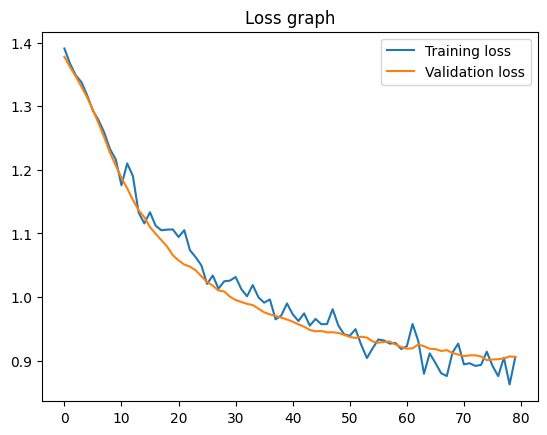

In [45]:
# Plot loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Loss graph")
plt.show()

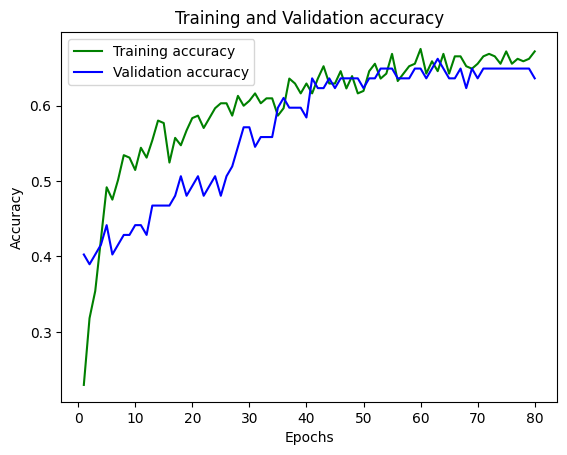

In [46]:
# plot accuracy graph
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,len(accuracy_val) + 1)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model's metrics on 20 datasets

In [47]:
from sklearn.metrics import classification_report

In [48]:
shuffled_df = lagged_data.sample(frac=1, random_state=4)

In [49]:
num_datasets = 20
datasets = np.array_split(shuffled_df, num_datasets)

In [50]:
xscaler = MinMaxScaler(feature_range=(0, 1))

In [51]:
saved_model = tf.keras.models.load_model('cnn_magnitude_7_day_lag_3_day_window')

In [52]:
saved_model.summary()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_206 (Conv1D)         (None, 3, 64)             704       
                                                                 
 max_pooling1d_206 (MaxPooli  (None, 2, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_206 (Dropout)       (None, 2, 64)             0         
                                                                 
 conv1d_207 (Conv1D)         (None, 2, 64)             8256      
                                                                 
 max_pooling1d_207 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_207 (Dropout)       (None, 1, 64)          

In [53]:
micro_precision_list = []
micro_recall_list = []
micro_f1_list = []

macro_precision_list = []
macro_recall_list = []
macro_f1_list = []

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

samples_precision_list = []
samples_recall_list = []
samples_f1_list = []

In [54]:
for dataset in datasets:
    X = dataset.iloc[:, :total_features].values
    y = dataset['feature1(t)'].values
    X = xscaler.fit_transform(X)
    X = X.reshape((X.shape[0], n_lag, n_features))
    
    y_pred = saved_model.predict(X)
    y_true = keras.utils.to_categorical(y, 4)
    
    max_indices = np.argmax(y_pred, axis=1)
    one_hot_encoded = np.zeros_like(y_pred)
    one_hot_encoded[np.arange(len(y_pred)), max_indices] = 1
    
    report = classification_report(y_true, one_hot_encoded, output_dict=True, zero_division=0)
    
    micro_precision_list.append(report['micro avg']['precision'])
    micro_recall_list.append(report['micro avg']['recall'])
    micro_f1_list.append(report['micro avg']['f1-score'])
    
    macro_precision_list.append(report['macro avg']['precision'])
    macro_recall_list.append(report['macro avg']['recall'])
    macro_f1_list.append(report['macro avg']['f1-score'])
    
    weighted_precision_list.append(report['weighted avg']['precision'])
    weighted_recall_list.append(report['weighted avg']['recall'])
    weighted_f1_list.append(report['weighted avg']['f1-score'])
    
    samples_precision_list.append(report['samples avg']['precision'])
    samples_recall_list.append(report['samples avg']['recall'])
    samples_f1_list.append(report['samples avg']['f1-score'])

1/1 [==============================] - 0s 18ms/step


In [55]:
avg_micro_precision = np.mean(micro_precision_list)
avg_micro_recall = np.mean(micro_recall_list)
avg_micro_f1 = np.mean(micro_f1_list)

avg_macro_precision = np.mean(macro_precision_list)
avg_macro_recall = np.mean(macro_recall_list)
avg_macro_f1 = np.mean(macro_f1_list)

avg_weighted_precision = np.mean(weighted_precision_list)
avg_weighted_recall = np.mean(weighted_recall_list)
avg_weighted_f1 = np.mean(weighted_f1_list)

avg_samples_precision = np.mean(samples_precision_list)
avg_samples_recall = np.mean(samples_recall_list)
avg_samples_f1 = np.mean(samples_f1_list)

In [56]:
print('Micro')
print(f'Average Micro Precision: {avg_micro_precision}')
print(f'Average Micro Recall: {avg_micro_recall}')
print(f'Average Micro F1-score: {avg_micro_f1}')

print('\n\nMacro')
print(f'Average Macro Precision: {avg_macro_precision}')
print(f'Average Macro Recall: {avg_macro_recall}')
print(f'Average Macro F1-score: {avg_macro_f1}')

print('\n\nWeighted')
print(f'Average Weighted Precision: {avg_weighted_precision}')
print(f'Average Weighted Recall: {avg_weighted_recall}')
print(f'Average Weighted F1-score: {avg_weighted_f1}')

print('\n\nSamples')
print(f'Average Samples Precision: {avg_samples_precision}')
print(f'Average Samples Recall: {avg_samples_recall}')
print(f'Average Samples F1-score: {avg_samples_f1}')

Micro
Average Micro Precision: 0.6680830039525693
Average Micro Recall: 0.6680830039525693
Average Micro F1-score: 0.6680830039525693


Macro
Average Macro Precision: 0.6823660714285713
Average Macro Recall: 0.6839384920634922
Average Macro F1-score: 0.6508564107461167


Weighted
Average Weighted Precision: 0.7069958513708514
Average Weighted Recall: 0.6680830039525693
Average Weighted F1-score: 0.6570610459349996


Samples
Average Samples Precision: 0.6680830039525693
Average Samples Recall: 0.6680830039525693
Average Samples F1-score: 0.6680830039525693


In [57]:
data = {
    'micro_precision': micro_precision_list,
    'micro_recall': micro_recall_list,
    'micro_f1': micro_f1_list,
    'macro_precision': macro_precision_list,
    'macro_recall': macro_recall_list,
    'macro_f1': macro_f1_list,
    'weighted_precision': weighted_precision_list,
    'weighted_recall': weighted_recall_list,
    'weighted_f1': weighted_f1_list,
    'samples_precision': samples_precision_list,
    'samples_recall': samples_recall_list,
    'samples_f1': samples_f1_list,
}

In [58]:
metrics_df = pd.DataFrame(data)

In [59]:
print(metrics_df)

    micro_precision  micro_recall  micro_f1  macro_precision  macro_recall  \
0          0.695652      0.695652  0.695652         0.700000      0.731250   
1          0.739130      0.739130  0.739130         0.776389      0.741071   
2          0.608696      0.608696  0.608696         0.595238      0.662500   
3          0.608696      0.608696  0.608696         0.589286      0.587500   
4          0.826087      0.826087  0.826087         0.854167      0.781250   
5          0.782609      0.782609  0.782609         0.866071      0.732143   
6          0.739130      0.739130  0.739130         0.770833      0.789286   
7          0.652174      0.652174  0.652174         0.645833      0.629167   
8          0.782609      0.782609  0.782609         0.775000      0.722222   
9          0.608696      0.608696  0.608696         0.578571      0.568452   
10         0.545455      0.545455  0.545455         0.613095      0.616667   
11         0.590909      0.590909  0.590909         0.559821    

In [62]:
# Get the minimum value of each column
min_values = metrics_df.min()

# Get the maximum value of each column
max_values = metrics_df.max()

print('Minimum Values:')
print(min_values)

print('\n\nMaximum Values:')
print(max_values)

Minimum Values:
micro_precision       0.545455
micro_recall          0.545455
micro_f1              0.545455
macro_precision       0.556250
macro_recall          0.549405
macro_f1              0.534524
weighted_precision    0.550379
weighted_recall       0.545455
weighted_f1           0.537879
samples_precision     0.545455
samples_recall        0.545455
samples_f1            0.545455
dtype: float64


Maximum Values:
micro_precision       0.826087
micro_recall          0.826087
micro_f1              0.826087
macro_precision       0.866071
macro_recall          0.833333
macro_f1              0.755462
weighted_precision    0.851449
weighted_recall       0.826087
weighted_f1           0.795177
samples_precision     0.826087
samples_recall        0.826087
samples_f1            0.826087
dtype: float64


In [65]:
metrics_df.to_csv('metrics/CNN magnitude 7 day lag 3 day window.csv', index=False)